#Experimental results for active learning sampling strategies

In [13]:
!/Users/niek/niek-env/bin/pip install blackcellmagic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 382.2 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 272.5 kB/s eta 0:00:001m277.1 kB/s eta 0:00:01



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [15]:
%load_ext blackcellmagic

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

In [20]:
%matplotlib inline

In [25]:
import os
import certifi

# Set the REQUESTS_CA_BUNDLE environment variable
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Check the path to the CA certificates bundle
print("CA Certificates Path:", os.environ["REQUESTS_CA_BUNDLE"])

CA Certificates Path: /Users/niek/niek-env/lib/python3.11/site-packages/certifi/cacert.pem


In [26]:
!export REQUESTS_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

In [ ]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {
    "rcv1": "rcv1_train.binary.bz2",
    "mushrooms": "mushrooms",
    "a1a": "a1a",
    "a2a": "a2a",
    "ijcnn": "ijcnn1.tr.bz2",
    "w8a": "w8a",
}


def load_mnist(data_dir):
    dataset = MNIST(
        data_dir, train=True, transform=None, target_transform=None, download=True
    )

    X, y = dataset.data.numpy(), dataset.targets.numpy()
    X = X / 255.0
    X = X.reshape((X.shape[0], -1))
    return X, y


def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)

        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context

        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [28]:
from torch.utils.data import Dataset

def get_dataset(dataset_name, split, datadir, exp_dict):
    train_flag = True if split == 'train' else False
    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1

        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)

    if dataset_name == 'tiny_imagenet':
        if train_flag:
            transform_train = transforms.Compose([
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                # transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagenette2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagewoof2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == "mnist":
        view = torchvision.transforms.Lambda(lambda x: x.view(-1).view(784))
        dataset = torchvision.datasets.MNIST(datadir, train=train_flag,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,)),
                                   view
                               ])
                               )

    if dataset_name == "cifar10":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR10(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name == "cifar100":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR100(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1
        # squared_max, squared_min = compute_max_eta_squared_loss(A)
        # logistic_max, logistic_min = compute_max_eta_logistic_loss(A)
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)


    if dataset_name in ["mushrooms", "w8a",
                        "rcv1", "ijcnn", 'a1a','a2a',
                        "mushrooms_convex", "w8a_convex",
                        "rcv1_convex", "ijcnn_convex", 'a1a_convex'
                        , 'a2a_convex']:

        sigma_dict = {"mushrooms": 0.5,
                      "w8a":20.0,
                      "rcv1":0.25 ,
                      "ijcnn":0.05}

        X, y = load_libsvm(dataset_name.replace('_convex', ''),
                           data_dir=datadir)

        labels = np.unique(y)

        y[y==labels[0]] = 0
        y[y==labels[1]] = 1
        # splits used in experiments
        splits = train_test_split(X, y, test_size=0.2, shuffle=True,
                    random_state=9513451)
        X_train, X_test, Y_train, Y_test = splits

        if "_convex" in dataset_name:
            if train_flag:
                # training set
                X_train = torch.FloatTensor(X_train.toarray())
                Y_train = torch.FloatTensor(Y_train)
                dataset = torch.utils.data.TensorDataset(X_train, Y_train)
            else:
                # test set
                X_test = torch.FloatTensor(X_test.toarray())
                Y_test = torch.FloatTensor(Y_test)
                dataset = torch.utils.data.TensorDataset(X_test, Y_test)

            return DatasetWrapper(dataset, split=split)

        if train_flag:
            # fname_rbf = "%s/rbf_%s_%s_train.pkl" % (datadir, dataset_name, sigma_dict[dataset_name])
            fname_rbf = "%s/rbf_%s_%s_train.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_train_X = np.load(fname_rbf)
            else:
                k_train_X = rbf_kernel(X_train, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_train_X)
                print('%s saved' % fname_rbf)

            X_train = k_train_X
            X_train = torch.FloatTensor(X_train)
            Y_train = torch.LongTensor(Y_train)

            dataset = torch.utils.data.TensorDataset(X_train, Y_train)

        else:
            fname_rbf = "%s/rbf_%s_%s_test.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_test_X = np.load(fname_rbf)
            else:
                k_test_X = rbf_kernel(X_test, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_test_X)
                print('%s saved' % fname_rbf)

            X_test = k_test_X
            X_test = torch.FloatTensor(X_test)
            Y_test = torch.LongTensor(Y_test)

            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "synthetic":
        margin = exp_dict["margin"]

        X, y, _, _ = make_binary_linear(n=exp_dict["n_samples"],
                                        d=exp_dict["d"],
                                        margin=margin,
                                        y01=True,
                                        bias=True,
                                        separable=exp_dict.get("separable", True),
                                        seed=42)
        # No shuffling to keep the support vectors inside the training set
        splits = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train, X_test, Y_train, Y_test = splits

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)

        Y_train = torch.LongTensor(Y_train)
        Y_test = torch.LongTensor(Y_test)

        if train_flag:
            dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        else:
            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "matrix_fac":
        fname = datadir + 'matrix_fac.pkl'
        if not os.path.exists(fname):
            data = generate_synthetic_matrix_factorization_data()
            ut.save_pkl(fname, data)

        A, y = ut.load_pkl(fname)

        X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2, random_state=9513451)

        training_set = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
        test_set = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))

        if train_flag:
            dataset = training_set
        else:
            dataset = test_set

    return DatasetWrapper(dataset, split=split)

class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}

class NlpDatasetWrapper(Dataset):
    def __init__(self, corpus, data, bptt):
        self.corpus = corpus
        self.data = data
        self.bptt = bptt

    def __len__(self):
        return self.data.size(0) // self.bptt

    def __getitem__(self, index):
        data, targets = nlp_utils.get_batch(self.data, index*self.bptt, self.bptt)

        return {"images":data,
                'labels':targets,
                'meta':{'indices':index}}

def rbf_kernel(A, B, sigma):
    # func = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=True)
    # result = func(torch.from_numpy(A.toarray())[None], torch.from_numpy(B.toarray())[None])

    # np.square(metrics.pairwise.pairwise_distances(A.toarray(), B.toarray(), metric="euclidean"))


    # numpy version
    distsq = np.square(metrics.pairwise.pairwise_distances(A, B, metric="euclidean"))
    K = np.exp(-1 * distsq/(2*sigma**2))
    return K

In [30]:
import os
import urllib
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = get_dataset("mushrooms", split="train", datadir="~", exp_dict={})
y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
X = np.array([data[i]["images"].numpy() for i in range(len(data))])

data = get_dataset("mushrooms", split="test", datadir="~", exp_dict={})
ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [31]:
X.shape

(6499, 6499)

In [32]:
y.shape

(6499,)

##Data generation

In [34]:
def plot_data(X, y, theta=[0, 0], r=1):
    plt.figure(figsize=(4, 4))
    pos = np.argwhere(y)[:, 0]
    neg = np.argwhere(1 - y)[:, 0]
    plt.plot(X[neg, 0], X[neg, 1], "r.")
    plt.plot(X[pos, 0], X[pos, 1], "b.")
    # plt.xticks([-1, 0, 1])
    # plt.yticks([-1, 0, 1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if np.linalg.norm(theta) > 0:
        theta_norm = theta / np.linalg.norm(theta)
        plt.plot([0, -r * theta_norm[0]], [0, r * theta_norm[1]], "g")
        plt.plot([0, r * theta_norm[0]], [0, -r * theta_norm[1]], "g")

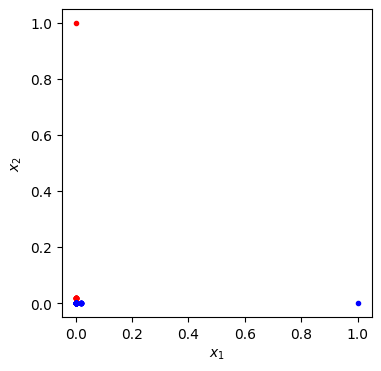

In [35]:
plot_data(X,y)

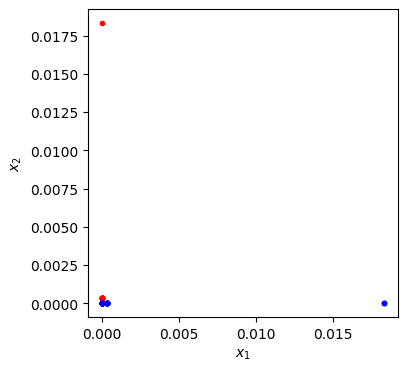

In [36]:
# Test dataset
plot_data(Xtest, ytest)

##Learning algorithms

In [ ]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def forward_squared_hinge(X, theta):
    fwd = np.matmul(X, theta)
    return fwd


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def grad_squared_hinge(x, y, theta):
    sy = 2 * y - 1
    grad = -np.max(1 - sy * np.dot(x, theta), 0) * sy * x
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def squared_hinge_loss(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    u = p * sy.T
    l = (1 / 2) * np.sum(np.maximum(1 - u, 0) ** 2)
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def accuracy_sign(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def sampling(x, a=1):
    return 1


sampling_exp = 0.1


def exp_sampling(x):
    sp = 0
    if x < 1:
        sp = 1 - math.exp(sampling_exp * (x - 1))
    return sp


mu = 1


def uncertainty_sampling(x):
    sp = min(1 / (1 + mu * abs(x)), 1)
    return sp


beta = 1


def squared_hinge_loss_sampling(x):
    x = x[0]
    sp = 0
    if x < 1:
        sp = (beta / 2) * (1 - (cmargin - 1) / (cmargin - x))
    return sp


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    #  if np.linalg.norm(theta) > 1:
    #    theta = theta / np.linalg.norm(theta)
    return newtheta

In [80]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

# CHANGE 4: Moved kappa, kappa0, polyakexp, omega to argument
def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    verbose=True,
):
    if verbose:
        print(f"Training with algorithm {mode}")
    phi = 2 * np.pi * np.random.rand()
    # theta = np.array([np.cos(phi), np.sin(phi)])
    # theta = np.array([theta_star[0], -theta_star[1]])
    # CHANGE 1: random initialisation is now of shape X.shape[1]
    theta = np.random.rand(X.shape[1])
    stheta = theta

    thetas = []
    losses = []
    losses_test = []
    slosses_test = []
    accuracies = []
    accuracies_test = []
    saccuracies_test = []
    labeled = []
    Delta = []
    sDelta = []
    probs = []
    samples = []

    # CHANGE 2: we loop over the data set size (X.shape[0]) rather than npoints
    # for i in range(npoints):
    for i in range(X.shape[0]):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        thetas.append(theta)

        if mode == "rand":
            pz = 1 / 2
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "opt":
            raise ValueError(
                "Can't run opt-mode because on real datasets we do not know theta_star!"
            )
            w = 10 * theta_star
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "squared_hinge":
            p = np.dot(xx, theta)
            pz = sampling((2 * yy - 1) * p)
            grad = grad_squared_hinge(xx, yy, theta)
        elif mode == "polyak":
            p = np.dot(xx, theta)
            grad = grad_squared_hinge(xx, yy, theta)
            #        zeta = min(kappa * loss(p, yy) / (np.linalg.norm(grad)**2), kappa0)
            zeta = min(
                kappa * 1 / (2 * np.linalg.norm(xx) ** 2), kappa0
            )  # squared hinge loss function
            if (2 * yy - 1) * p > 1:
                zeta = 0
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-bec":  # binary cross entropy
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-becpi":  # binary cross entropy pi sampling
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            grad = zeta * grad / pz

        # sampling
        z = np.random.binomial(1, pz)

        l = loss(p, yy) + lam * np.linalg.norm(theta)
        losses.append(l)

        stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta

        a = accuracy(p, yy)
        accuracies.append(a)

        labeled.append(z)
        probs.append(pz)

        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            samples.append(i)
        else:
            theta = theta

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(theta)
        losses_test.append(ltest)

        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)

        p = forward(Xtest, theta)
        a = accuracy(p, ytest)
        accuracies_test.append(a)

        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)

        if verbose and i % 1000 == 0:
            print("loss:", l, "theta:", theta, "stheta:", stheta)

    # CHANGE 3: We write all results to a dict for easier access
    return {
        "losses": losses,
        "losses_test": losses_test,
        "slosses_test": slosses_test,
        "labeled": labeled,
        "theta": theta,
        "stheta": stheta,
        "probs": probs,
        "accuracies": accuracies,
        "accuracies_test": accuracies_test,
        "saccuracies_test": saccuracies_test,
        "samples": samples,
        "thetas": thetas,
    }

##Evaluation


###Cross-entropy loss, different sampling strategies

####Random sampling

In [46]:
eta = 0.1
lam = 2
d = train_model(X, y, Xtest, ytest, mode = "rand", eta = eta, lam = lam)
#losses, losses_test, slosses_test, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "rand", eta = eta, lam = lam)

loss: 94.13226777398128 theta: [0.97157025 0.72037287 0.1182044  ... 0.11798222 0.6239394  0.37466347] stheta: [0.97157025 0.72037287 0.1182044  ... 0.11798222 0.6239394  0.37466347]
loss: 0.9229274916823039 theta: [ 2.34959862e-07 -9.18845671e-08 -1.24296337e-05 ...  3.15517547e-07
 -9.84770882e-09 -1.13034236e-07] stheta: [0.02301445 0.01701498 0.00151154 ... 0.00283688 0.01473836 0.00885857]
loss: 0.9229536313944726 theta: [ 1.41733243e-08 -9.50224885e-08 -3.49944008e-08 ...  4.02925546e-09
 -5.67057154e-08 -1.84099448e-08] stheta: [0.01152254 0.00851088 0.00075554 ... 0.00141916 0.00736167 0.00443147]
loss: 0.922971086251883 theta: [ 4.80596364e-05 -3.22352188e-08 -9.96301570e-10 ...  1.61618424e-08
 -5.18379197e-08 -7.28198613e-07] stheta: [0.00769384 0.00567056 0.00050344 ... 0.00095141 0.00490832 0.00294892]
loss: 0.9229826246014484 theta: [ 2.82257822e-07 -5.10766400e-09 -1.19618296e-09 ...  2.50458572e-07
 -2.56753746e-07 -1.17340630e-08] stheta: [0.00577145 0.0042529  0.00037

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparam_results.csv")

search_spaces = {
    #"rand": {
    #    'eta': hp.loguniform('eta', -5, -1),
    #    'lam': hp.quniform('lam', 0.5, 4, 0.5),
   # },
    "uncertainty": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.quniform('lam', 0.5, 4, 0.5)
    },
    "squared_hinge": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.quniform('lam', 0.5, 4, 0.5)
    },
    "polyak": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.quniform('lam', 0.5, 4, 0.5),
        'kappa': hp.quniform('kappa', 0.5, 2, 0.1),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    },
    "polyak-bec": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.quniform('lam', 0.5, 4, 0.5),
        'kappa': hp.quniform('kappa', 0.5, 2, 0.1),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    },
    "polyak-becpi": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.quniform('lam', 0.5, 4, 0.5),
        'kappa': hp.quniform('kappa', 0.5, 2, 0.1),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    }
} 

# Create a Trials object to store optimization results
trials = {}
best_knowns = {}
trials = {
    "rand": Trials(),
    "uncertainty": Trials(),
    "squared_hinge": Trials(),
    "polyak": Trials(),
    "polyak-bec": Trials(),
    "polyak-becpi": Trials()
}

for method in search_spaces:
    trials[method] = Trials()
    best_knowns[method] = {
        "best_loss": float('inf'),
        "best_params": None
    }

# Define the original function with all arguments
def train_and_get_last_loss(X, y, Xtest, ytest, mode, params):
    d = train_model(X, y, Xtest, ytest, mode=mode, verbose=False, **params)
    
    current_loss = d["losses_test"][-1]
    
    if current_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = current_loss
        best_knowns[method]["best_params"] = params
        print("New best parameters:", best_knowns[method]["best_params"])

        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file, delimiter='\t')

            if not os.path.exists(csv_file):
                writer.writerow(['Method', 'Best Loss', 'Best Params'])  # Write header if file doesn't exist

            writer.writerow([method, best_knowns[method]["best_loss"], best_knowns[method]["best_params"]])

    return current_loss

# Fix some arguments using functools.partial

for method in search_spaces:
    get_loss_after_training = functools.partial(
        train_and_get_last_loss,
        X_train, y_train, X_val, y_val, method
    )

    # Perform hyperparameter optimization using Hyperopt
    best = fmin(
        fn=get_loss_after_training,
        space=search_spaces[method],
        algo=tpe.suggest,
        max_evals=40,
        trials=trials[method],
    )


New best parameters:                                                                                                                                                                                                                              
{'eta': 0.10674065721075696, 'lam': 2.5}                                                                                                                                                                                                          
New best parameters:                                                                                                                                                                                                                              
{'eta': 0.05337182473639247, 'lam': 3.5}                                                                                                                                                                                                          
New best parameters:        

# Use best hyperparams to construct plot

In [54]:
hyperparam_results = pd.read_csv("hyperparam_results.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [64]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [65]:
min_losses

,algorithm,loss
0,polyak,0.728886
1,polyak-bec,0.710367
2,polyak-becpi,0.701853
3,rand,0.737304
4,squared_hinge,0.767320
5,uncertainty,0.745050


In [68]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [77]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [78]:
hyperparam_per_algo

{'polyak': {'eta': 0.009914645814388511,
  'kappa': 1.4000000000000001,
  'kappa0': 0.08213113010446994,
  'lam': 1.5},
 'polyak-bec': {'eta': 0.029848338795592875,
  'kappa': 1.5,
  'kappa0': 0.0776871329078532,
  'lam': 0.5},
 'polyak-becpi': {'eta': 0.006764676388466573,
  'kappa': 2.0,
  'kappa0': 0.06632889103341866,
  'lam': 2.5},
 'rand': {'eta': 0.014942622961058376, 'lam': 0.5},
 'squared_hinge': {'eta': 0.010516324395787422, 'lam': 0.5},
 'uncertainty': {'eta': 0.006984112970608457, 'lam': 1.5}}

In [82]:
testset_results_per_algo = {
    algorithm: train_model(X, y, Xtest, ytest, mode=algorithm, verbose=True, **hyperparam_per_algo[algorithm])
    for algorithm in hyperparam_per_algo.keys()
}

Training with algorithm polyak
loss: 71.32014829306516 theta: [0.25503758 0.01955727 0.15228476 ... 0.1404619  0.50962158 0.26554713] stheta: [0.25503758 0.01955727 0.15228476 ... 0.1404619  0.50962158 0.26554713]
loss: 9.764610254931215 theta: [0.02617989 0.00190955 0.01561882 ... 0.01447171 0.05231162 0.02725612] stheta: [0.09787376 0.00750076 0.05840714 ... 0.05391978 0.19557214 0.10190409]
loss: 5.412206401917296 theta: [0.00323947 0.00023424 0.00193069 ... 0.00179023 0.00646929 0.00337165] stheta: [0.0544628  0.00415318 0.03249978 ... 0.0300143  0.10882667 0.05670481]
loss: 6.567219804452002 theta: [4.17805801e-04 2.94621902e-05 2.47308616e-04 ... 2.29884443e-04
 8.29618233e-04 3.97464416e-04] stheta: [0.03678042 0.00280284 0.02194734 ... 0.02027012 0.07349267 0.03829063]
loss: 0.038122190231773434 theta: [5.48065227e-05 3.32738716e-06 3.07269850e-05 ... 3.05016990e-05
 1.06015485e-04 4.98965086e-05] stheta: [0.02763208 0.00210524 0.01648782 ... 0.01522833 0.05521177 0.02876234]
l

loss: 0.7450098818655044 theta: [ 1.19026250e-05 -8.99801770e-05 -4.31121165e-05 ...  9.53037371e-07
 -4.24032282e-07 -2.19626336e-05] stheta: [0.00747595 0.04949878 0.02723589 ... 0.01709284 0.05916486 0.043511  ]


In [ ]:
def plot_eval(d):
    f, axs = plt.subplots(1, 3, figsize=(16, 3))
    axs[0].plot(d["losses"], ".")
    axs[0].step(np.cumsum(d["losses"]) / (np.arange(len(d["losses"])) + 1), "r")
    axs[0].set_xlabel("number of iterations")
    axs[0].set_ylabel("train loss")
    axs[0].set_ylim(
        [0, 2 * np.max(np.cumsum(d["losses"]) / (np.arange(len(d["losses"])) + 1))]
    )
    axs[1].plot(d["accuracies"], ".")
    axs[1].step(np.cumsum(d["accuracies"]) / (np.arange(len(d["accuracies"])) + 1), "r")
    axs[1].set_xlabel("number of iterations")
    axs[1].set_ylabel("train accuracy")
    axs[2].plot(np.cumsum(d["labeled"]), d["accuracies"], ".")
    axs[2].step(
        np.cumsum(d["labeled"]),
        np.cumsum(d["accuracies"]) / (np.arange(len(d["accuracies"])) + 1),
        "r",
    )
    axs[2].set_xlabel("number of labels")
    axs[2].set_ylabel("train accuracy")
    f.tight_layout()

    f, axs = plt.subplots(1, 3, figsize=(16, 3))
    axs[0].step(np.arange(len(d["losses_test"])), d["losses_test"])
    axs[0].step(np.arange(len(d["slosses_test"])), d["slosses_test"], "r")
    axs[0].set_xlabel("number of iterations")
    axs[0].set_ylabel("test loss")
    axs[0].set_ylim([0, 2 * np.max(d["slosses_test"])])
    axs[1].step(np.arange(len(d["accuracies_test"])), d["accuracies_test"])
    axs[1].step(np.arange(len(d["saccuracies_test"])), d["saccuracies_test"], "r")
    axs[1].set_xlabel("number of iterations")
    axs[1].set_ylabel("test accuracy")
    axs[2].step(np.cumsum(d["labeled"]), d["accuracies_test"])
    axs[2].step(np.cumsum(d["labeled"]), d["saccuracies_test"], "r")
    axs[2].set_xlabel("number of labels")
    axs[2].set_ylabel("test accuracy")
    f.tight_layout()

    the = np.array(d["thetas"])
    theta_angle = np.arctan2(the[:, 1], the[:, 0]) * 180 / np.pi - 90

    f, axs = plt.subplots(1, 4, figsize=(16, 3))
    axs[0].plot(d["Delta"])
    axs[0].step(d["sDelta"], "r")
    axs[0].set_xlabel("number of iterations")
    axs[0].set_ylabel(r"$||\theta-\theta^*||$")
    axs[1].plot(theta_angle)
    axs[1].set_xlabel("number of iterations")
    axs[1].set_ylabel(r"$\theta$ angle")
    axs[2].plot(np.cumsum(labeled))
    axs[2].set_xlabel("number of iterations")
    axs[2].set_ylabel("number of labels")
    axs[3].plot(d["probs"], ".")
    axs[3].set_xlabel("number of iterations")
    axs[3].set_ylabel("sampling probability")
    f.tight_layout()

In [94]:
def plot_evals(results_dict, figsize=(18, 6)):
    num_algorithms = len(results_dict)
    
    # Create subplots for training loss and accuracy
    f, axs = plt.subplots(1, 3, figsize=figsize)
    
    for algorithm, d in results_dict.items():
        # Training loss plot
        axs[0].plot(d["losses"], '.', label=algorithm)
        axs[0].step(np.cumsum(d["losses"]) / (np.arange(len(d["losses"])) + 1), 'r')
        
        # Training accuracy plot
        axs[1].plot(d["accuracies"], '.', label=algorithm)
        axs[1].step(np.cumsum(d["accuracies"]) / (np.arange(len(d["accuracies"])) + 1), 'r')
        
        # Number of labels vs. accuracy plot
        axs[2].plot(np.cumsum(d["labeled"]), d["accuracies"], '.', label=algorithm)
        axs[2].step(
            np.cumsum(d["labeled"]),
            np.cumsum(d["accuracies"]) / (np.arange(len(d["accuracies"])) + 1),
            'r',
        )
    
    for ax in axs:
        ax.set_xlabel('number of iterations')
    
    axs[0].set_ylabel('train loss')
    axs[0].set_ylim([0, 2 * np.max(np.cumsum(d["losses"]) / (np.arange(len(d["losses"])) + 1))])
    axs[1].set_ylabel('train accuracy')
    axs[2].set_xlabel('number of labels')
    axs[2].set_ylabel('train accuracy')
    
    # Add legend to distinguish algorithms
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    f.tight_layout()
    
    # Create subplots for test loss and accuracy
    f, axs = plt.subplots(1, 3, figsize=figsize)
    
    for algorithm, d in results_dict.items():
        # Test loss plot
        axs[0].step(np.arange(len(d["losses_test"])), d["losses_test"], label=algorithm)
        axs[0].step(np.arange(len(d["slosses_test"])), d["slosses_test"], 'r')
        
        # Test accuracy plot
        axs[1].step(np.arange(len(d["accuracies_test"])), d["accuracies_test"], label=algorithm)
        axs[1].step(np.arange(len(d["saccuracies_test"])), d["saccuracies_test"], 'r')
        
        # Number of labels vs. test accuracy plot
        axs[2].step(np.cumsum(d["labeled"]), d["accuracies_test"], label=algorithm)
        axs[2].step(np.cumsum(d["labeled"]), d["saccuracies_test"], 'r')
    
    for ax in axs:
        ax.set_xlabel('number of iterations')
    
    axs[0].set_ylabel('test loss')
    axs[0].set_ylim([0, np.max([d["slosses_test"] for d in results_dict.values()])])
    axs[1].set_ylabel('test accuracy')
    axs[2].set_xlabel('number of labels')
    axs[2].set_ylabel('test accuracy')
    
    # Add legend to distinguish algorithms
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    f.tight_layout()
    
    # Create subplots for other metrics
    f, axs = plt.subplots(1, 4, figsize=figsize)
    
    for algorithm, d in results_dict.items():
        # Change in theta plot
        #axs[0].plot(d["Delta"], label=algorithm)
        #axs[0].step(d["sDelta"], 'r')
        
        # Theta angle plot
        the = np.array(d["thetas"])
        theta_angle = np.arctan2(the[:, 1], the[:, 0]) * 180 / np.pi - 90
        axs[1].plot(theta_angle, label=algorithm)
        
        # Cumulative sum of labeled samples
        axs[2].plot(np.cumsum(d["labeled"]), label=algorithm)
        
        # Sampling probability plot
        axs[3].plot(d["probs"], '.', label=algorithm)
    
    axs[0].set_xlabel('number of iterations')
    axs[0].set_ylabel(r"$||\theta-\theta^*||$")
    axs[1].set_xlabel('number of iterations')
    axs[1].set_ylabel(r"$\theta$ angle")
    axs[2].set_xlabel('number of iterations')
    axs[2].set_ylabel('number of labels')
    axs[3].set_xlabel('number of iterations')
    axs[3].set_ylabel('sampling probability')
    
    # Add legend to distinguish algorithms
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()
    
    f.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


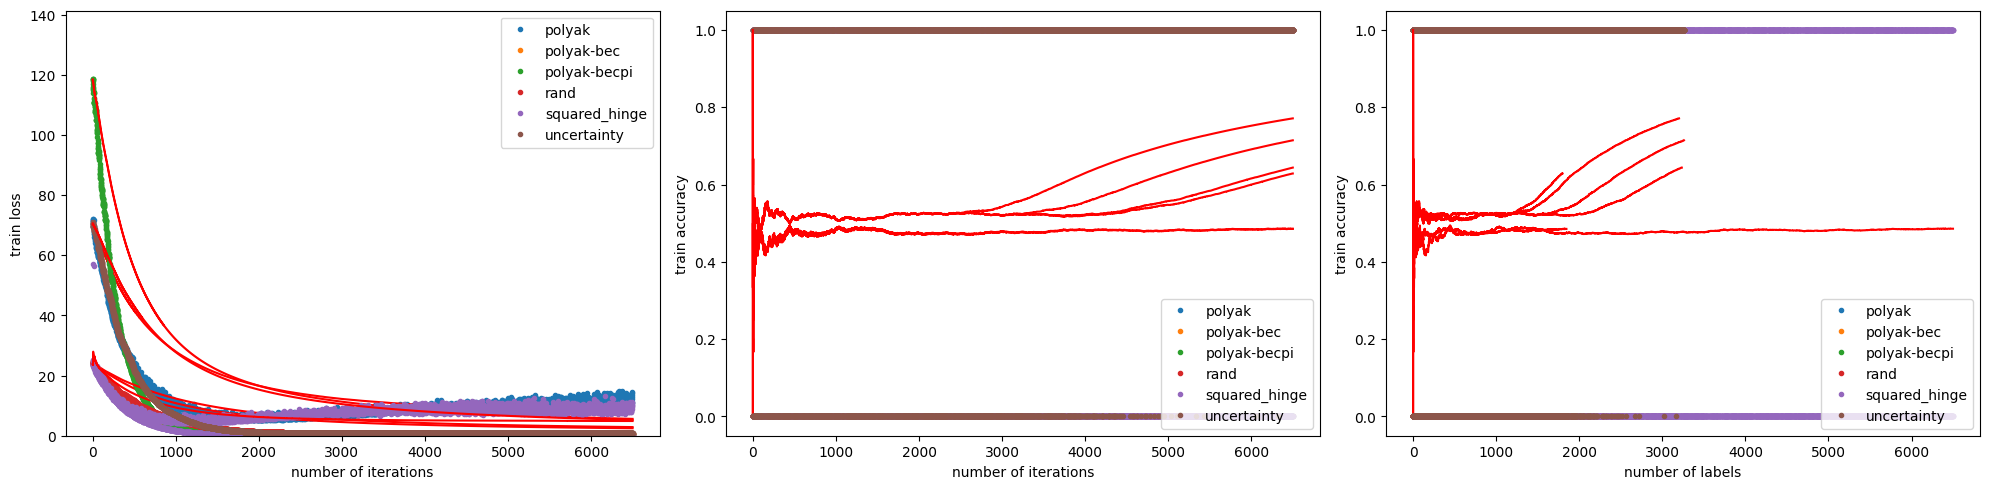

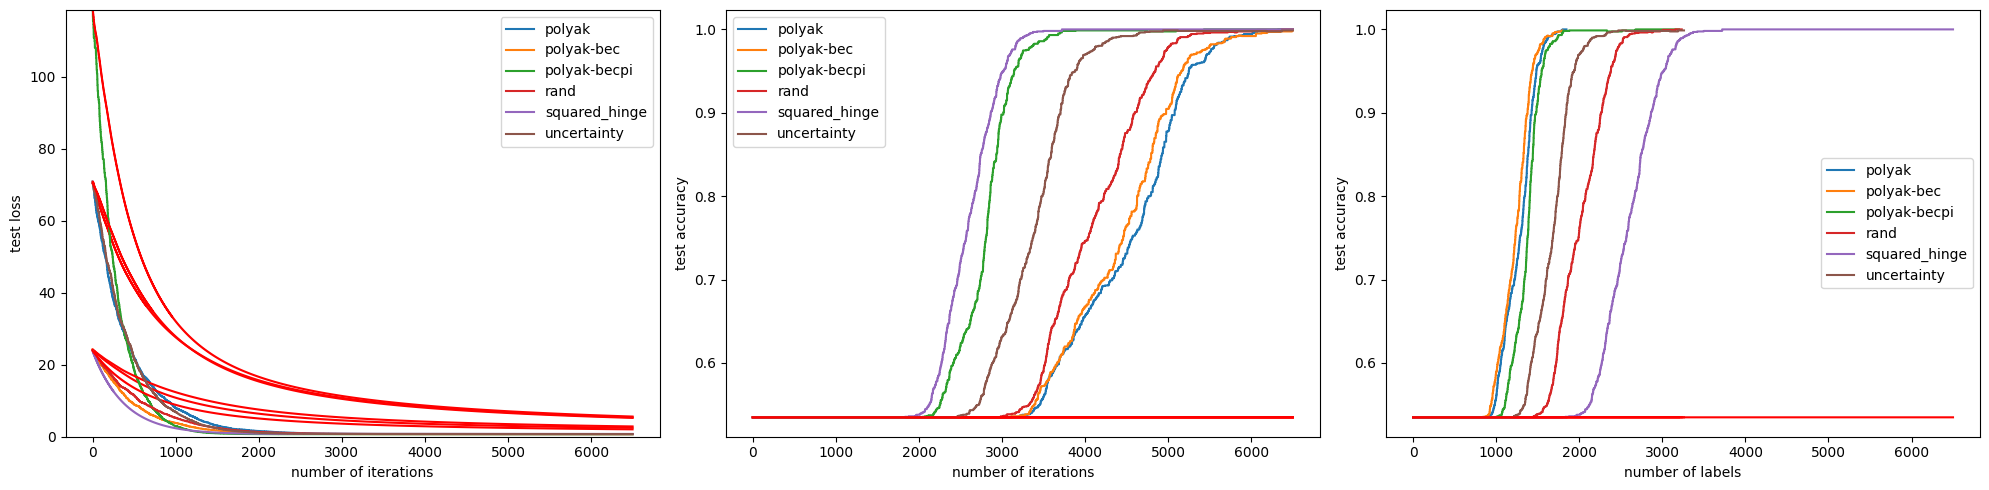

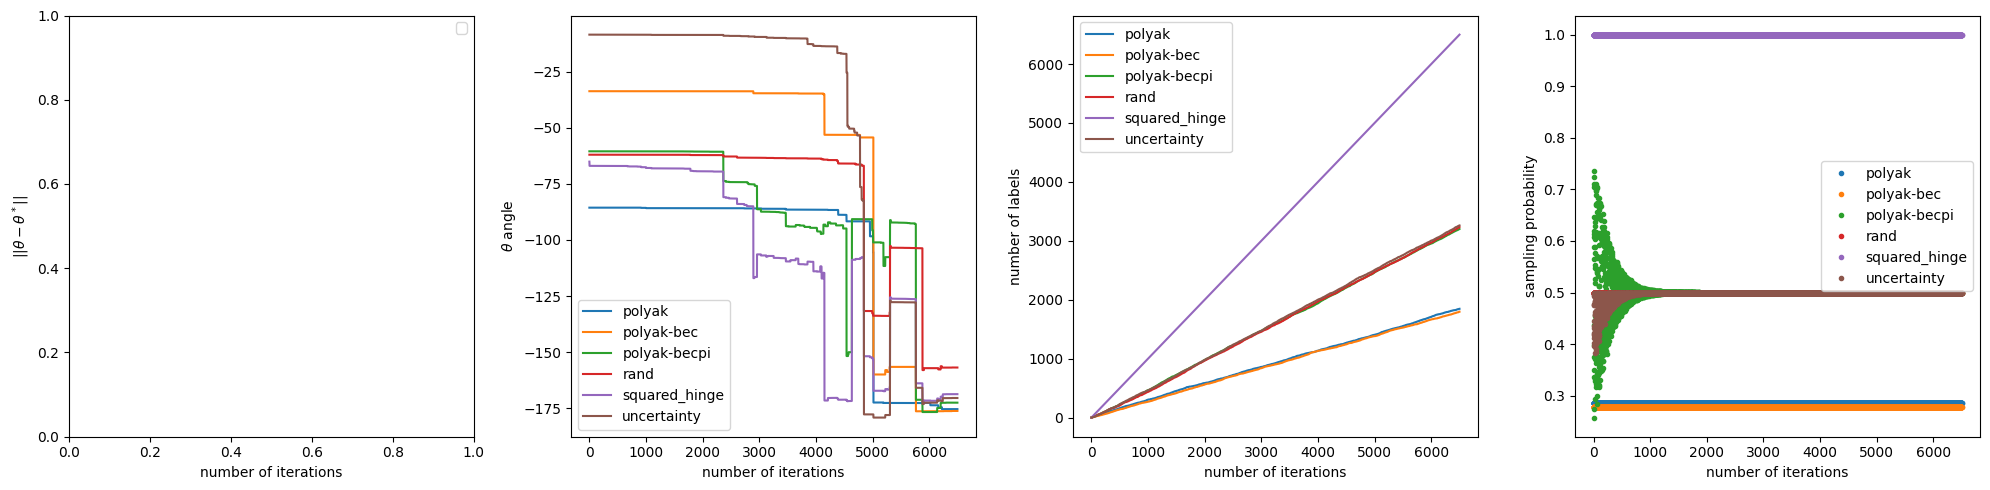

In [95]:
plot_evals(testset_results_per_algo, figsize=(20, 5))

In [ ]:
plot_eval(d["losses"], d["losses_test"], d["slosses_test"], 0, 0, d["labeled"], d["probs"], d["accuracies"], d["accuracies_test"], d["saccuracies_test"], d["thetas"])

In [ ]:
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

In [ ]:
losses_test_rnd = losses_test
slosses_test_rnd = slosses_test
losses_train_rnd = np.cumsum(losses) / (np.arange(len(losses))+1)
labeled_rnd = labeled

####0-1 loss sampling using true hypothesis class

In [ ]:
eta = 1/(2*radius**2)
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "opt", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)
losses_test_opt = losses_test
slosses_test_opt = slosses_test
losses_train_opt = np.cumsum(losses) / (np.arange(len(losses))+1)
labeled_opt = labeled

####Uncertainty sampling

In [ ]:
eta = 1/(2*radius**2)
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "uncertainty", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)
losses_test_uncertainty = losses_test
slosses_test_uncertainty = slosses_test
losses_train_uncertainty = np.cumsum(losses) / (np.arange(len(losses))+1)
labeled_uncertainty = labeled

##Train loss comparison

In [ ]:
plt.plot(np.cumsum(labeled_rnd), losses_train_rnd, 'b')
plt.plot(np.cumsum(labeled_opt), losses_train_opt, 'r')
plt.plot(np.cumsum(labeled_uncertainty), losses_train_uncertainty, 'g')
plt.legend(["Random", "Optimal", "Uncertainty"])
plt.xlabel("Number of labels")
plt.ylabel("Train loss");
#plt.ylim([1.05, 1.2])
plt.yscale('linear')
plt.xscale('linear');

NameError: ignored

##Test loss comparison

In [ ]:
plt.plot(np.cumsum(labeled_rnd), losses_test_rnd)
plt.plot(np.cumsum(labeled_opt), losses_test_opt, 'r')
plt.plot(np.cumsum(labeled_uncertainty), losses_test_uncertainty, 'g')
plt.legend(["Random", "Optimal", "Uncertainty"])
plt.xlabel("Number of labels")
plt.ylabel("Test loss")
#plt.ylim([1.05, 1.2])
plt.yscale('linear')
plt.xscale('linear');

NameError: ignored

In [ ]:
plt.plot(np.cumsum(labeled_rnd), slosses_test_rnd)
plt.plot(np.cumsum(labeled_opt), slosses_test_opt, 'r')
plt.plot(np.cumsum(labeled_uncertainty), slosses_test_uncertainty, 'g')
plt.legend(["Random", "Optimal", "Uncertainty"])
plt.xlabel("Number of labels")
plt.ylabel("Test loss w smoothed param")
#plt.ylim([1.05, 1.2])
plt.yscale('linear')
plt.xscale('linear');

NameError: ignored

##Squared hinge loss, loss function sampling

### Power sampling function

Sampling function:
$$
\pi(u)=\frac{\beta}{2}\left(1-\frac{c-1}{c-u}\right) \hbox{ for } u\leq 1 \hbox{ and } \pi(u) = 0 \hbox{ otherwise}
$$

where $\beta$ is a parameter such that $0<\beta \leq 2$ and $c$ is a parameter such that $1\leq c \leq \rho^*$

####Setting $\beta = 2$, $c=1$

In [ ]:
alpha = 2*radius**2
beta = 2
eta = beta/alpha

cmargin = 1

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")

IndexError: ignored

####Setting $\beta = 2$, $c=\rho^*$

In [ ]:
alpha = 2*radius**2
beta = 2
eta = beta/alpha

cmargin = margin

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")

IndexError: ignored

####Setting $\beta = 0.5$, $c=1$

In [ ]:
alpha = 2*radius**2
beta = 0.5
eta = beta/alpha

cmargin = 1

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")


IndexError: ignored

####Setting $\beta = 0.5$, $c=\rho^*$

In [ ]:
alpha = 2*radius**2
beta = 0.5
eta = beta/alpha

cmargin = margin

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")


IndexError: ignored

####Setting $\beta = 0.1$, $c=1$

In [ ]:
alpha = 2*radius**2
beta = 0.1
eta = beta/alpha

cmargin = 1

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")


IndexError: ignored

####Setting $\beta = 0.1$, $c=\rho^*$

In [ ]:
alpha = 2*radius**2
beta = 0.1
eta = beta/alpha

cmargin = margin

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = squared_hinge_loss_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")


IndexError: ignored

### Exponential sampling function

Sampling function:
$$
\pi(u) = 1-e^{a(u-1)} \hbox{ for } u\leq 1 \hbox{ and } \pi(u) = 0 \hbox{ otherwise }
$$

In [ ]:
alpha = 2*radius**2
c = 1-math.exp(-sampling_exp)
beta = 2*(margin-1)*c
eta = beta/alpha

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = exp_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")
print(c)
print(1/(margin-1))


IndexError: ignored

###Power sampling function varying $\beta$

In [ ]:
alpha = 2*radius**2

cmargin = margin

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign

pbeta = np.linspace(0.05, 2, 10)

macc = []
mloss = []
fraclab = []

for b in pbeta:
  print(b)
  beta = b
  eta = beta/alpha
  sampling = squared_hinge_loss_sampling
  losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
  macc.append(np.mean(accuracies))
  mloss.append(np.mean(losses))
  fraclab.append(np.mean(labeled))


0.05


IndexError: ignored

In [ ]:
def plot_eval2(fraclab, mloss, macc):

  f, axs = plt.subplots(1, 2, figsize = (16,3))

  axs[0].plot(100*np.array(fraclab), mloss, '.')
  axs[0].step(100*np.array(fraclab), mloss)
  axs[0].set_xlabel('points labelled (%)')
  axs[0].set_ylabel('mean train loss');
  #axs[0].set_xlim([0,100])

  axs[1].plot(100*np.array(fraclab), macc, '.')
  axs[1].step(100*np.array(fraclab), macc)
  axs[1].set_xlabel('points labelled (%)')
  axs[1].set_ylabel('train accuracy');
  #axs[1].set_xlim([0,100]);

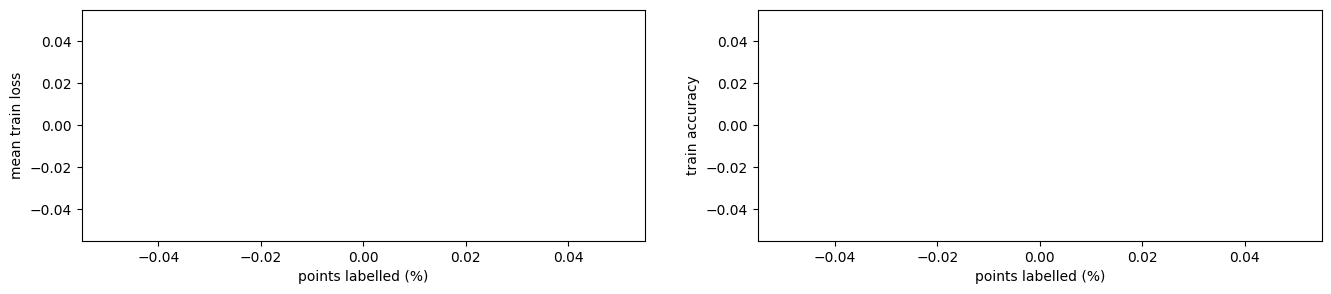

In [ ]:
plot_eval2(fraclab, mloss, macc)

###Uncertainty sampling

Sampling function:

$$
\pi(u) = \frac{1}{1+\mu |u|}
$$

where $\mu$ is a parameter such that $\mu > 0$

In [ ]:
mu = 1

alpha = (radius**2)*max(1,1/mu)
beta = min((margin-1)/(1+mu),1/mu)
eta = beta/alpha

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
sampling = uncertainty_sampling
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)

thetainit = np.array([theta_star[0], -theta_star[1]])

cfactor = (np.linalg.norm(theta_star-thetainit)**2) * alpha/beta**2

print(f"bound factor = {cfactor}")


IndexError: ignored

#### Varying $\mu$

In [ ]:
alpha = 2*radius**2

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign

pmu = np.linspace(0.1, 10, 10)

macc = []
mloss = []
fraclab = []

for m in pmu:
  print(m)
  mu = m
  alpha = (radius**2)*max(1,1/mu)
  beta = min((margin-1)/(1+mu),1/mu)
  eta = beta/alpha
  sampling = uncertainty_sampling
  losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "squared_hinge", eta = eta, lam = lam)
  macc.append(np.mean(accuracies))
  mloss.append(np.mean(losses))
  fraclab.append(np.mean(labeled))


0.1


IndexError: ignored

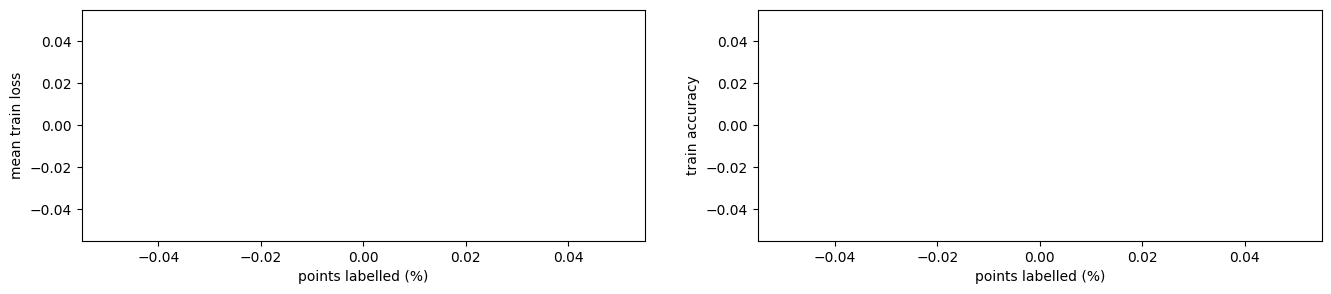

In [ ]:
plot_eval2(fraclab, mloss, macc)

##Polyak's sampling

Sampling probability: $\pi(x,y,\theta) = \zeta(x,y,\theta)^\alpha$

Step size: $\zeta(x,y,\theta)^{1-\alpha}$

where $\alpha$ is a parameter such that $0\leq \alpha \leq 1$ and

$$
\zeta(x,y,\theta) = \min\left\{\kappa \frac{\ell(x,y,\theta)}{||\nabla_\theta \ell(x,y,\theta)||^2}, \kappa_0\right\} \hbox{ if } ||\nabla_\theta \ell(x,y,\theta)|| > 0 \hbox{ and } \zeta(x,y,\theta) = 0 \hbox{ otherwise }
$$

and $\kappa,\kappa_0$ are positive valued parameters

Note: if $\alpha = 0$, the label of each example is queried and we have an algorithm with adaptive step size

Note: for squared hinge loss function,
$$
\frac{\ell(x,y,\theta)}{||\nabla_\theta \ell(x,y,\theta)||^2} = \frac{1}{2||x||^2}
$$


### Setting $\alpha = 0$

In [ ]:
eta = 1
kappa0 = 1

polyakexp = 0

beta = radius**2
kappa = (2*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


IndexError: ignored

###Setting $\alpha = 0.001$

In [ ]:
eta = 1
kappa0 = 1

polyakexp = 1e-2

beta = radius**2
kappa = (2*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


### Setting $\alpha = 0.01$

In [ ]:
eta = 1
kappa0 = 1

polyakexp = 1e-1

beta = radius**2
kappa = (2*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


### Setting $\alpha = 0.5$

In [ ]:
eta = 1
kappa0 = 1

polyakexp = 0.5

beta = radius**2
kappa = (2*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


IndexError: ignored

###Varying $\alpha$

In [ ]:
eta = 1
kappa0 = 1

beta = radius**2

lam = 0
loss = squared_hinge_loss
forward = forward_squared_hinge
accuracy = accuracy_sign

ppol = np.linspace(0, 0.5, 10)

macc = []
mloss = []
fraclab = []

for p in ppol:
  print(p)
  polyakexp = p
  kappa = (2*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))
  losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak", eta = eta, lam = lam)
  macc.append(np.mean(accuracies))
  mloss.append(np.mean(losses))
  fraclab.append(np.mean(labeled))


0.0


IndexError: ignored

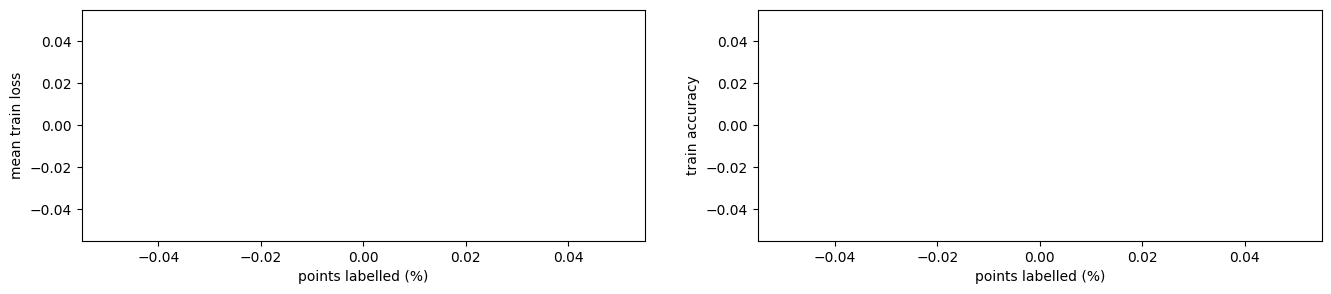

In [ ]:
plot_eval2(fraclab, mloss, macc)

##Binary cross-entropy loss

loss: 24.385130865312046 theta: [-0.65276643  0.40282125] stheta: [-0.70710678 -0.70710678]
loss: 0.0 theta: [-1.33403262  1.25320551] stheta: [-1.02155981  0.98938353]
loss: 4.4408920985006364e-15 theta: [-1.59443703  1.59587269] stheta: [-1.25004326  1.21433475]
loss: 0.0 theta: [-1.7609844   1.80367644] stheta: [-1.39463015  1.37112187]
loss: 0.0 theta: [-1.86374991  1.96698021] stheta: [-1.51562362  1.48915434]
loss: 0.0 theta: [-1.99313364  2.14295401] stheta: [-1.61257262  1.59137136]
loss: 0.0 theta: [-2.12066338  2.23305151] stheta: [-1.69554199  1.68390536]
loss: 0.0 theta: [-2.30006723  2.22620225] stheta: [-1.76923809  1.76431637]
loss: 0.0 theta: [-2.29120249  2.31804034] stheta: [-1.8302606   1.83134659]
loss: 8.703931993875844e-07 theta: [-2.34129621  2.39341354] stheta: [-1.88483809  1.88838735]
loss: 0.0 theta: [-2.35532118  2.44765334] stheta: [-1.93411937  1.93810997]
loss: 1.807299248824107e-08 theta: [-2.44878402  2.43662972] stheta: [-1.97888543  1.98125034]
loss: 

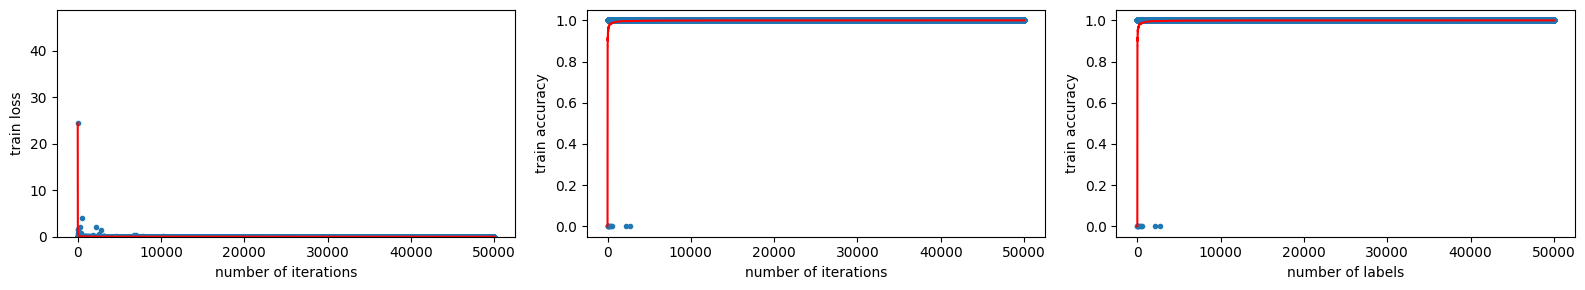

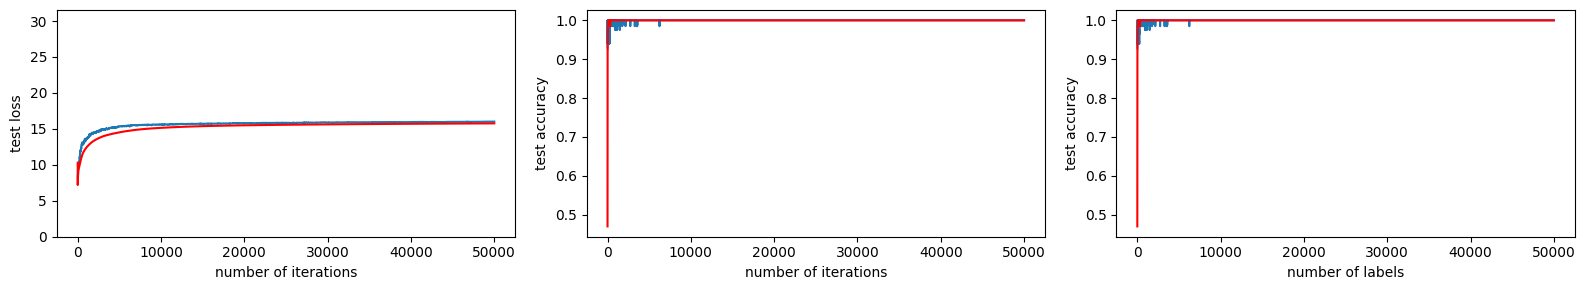

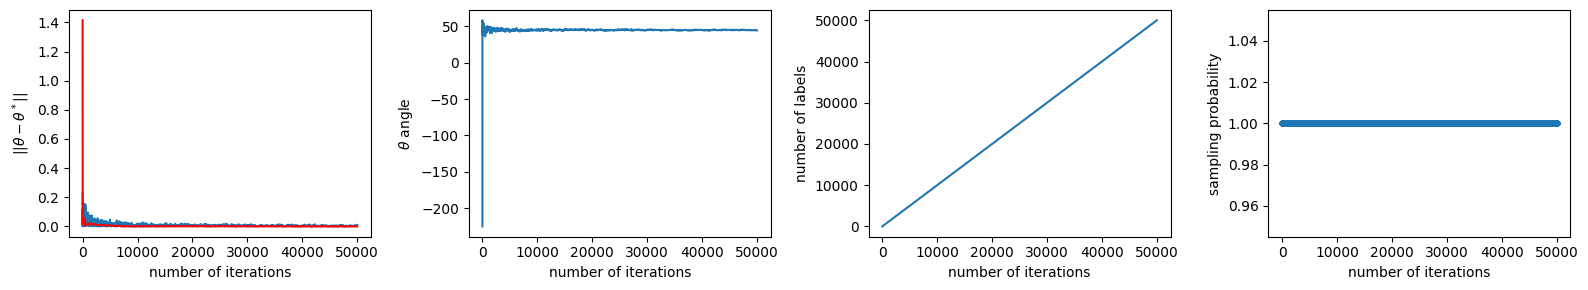

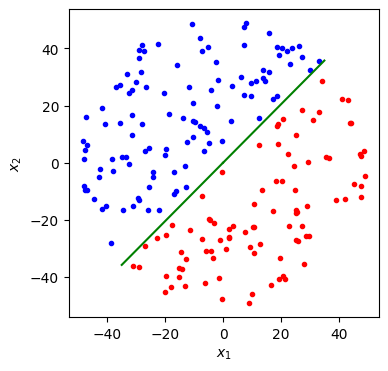

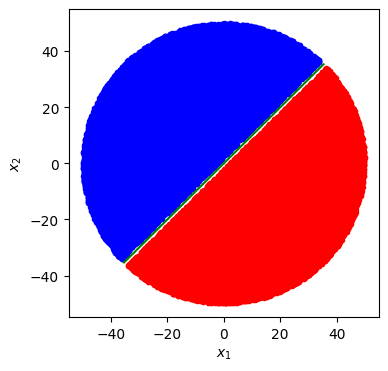

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1

polyakexp = 0

beta = 0.25*radius**2
kappa = (1.5*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-bec", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.65454983  0.36639433] stheta: [-0.70710678 -0.70710678]
loss: 0.0 theta: [-1.33051982  1.24754328] stheta: [-1.01446016  0.98168479]
loss: 5.1070259132757335e-15 theta: [-1.58839071  1.58692888] stheta: [-1.24464876  1.20610007]
loss: 0.0 theta: [-1.75195628  1.79525954] stheta: [-1.38822727  1.36279162]
loss: 0.0 theta: [-1.85612818  1.95722738] stheta: [-1.5088321   1.48068114]
loss: 0.0 theta: [-1.98340651  2.132184  ] stheta: [-1.60531786  1.58266222]
loss: 0.0 theta: [-2.10895927  2.22274508] stheta: [-1.68757039  1.67497124]
loss: 0.0 theta: [-2.28109444  2.21792657] stheta: [-1.76052984  1.75491623]
loss: 0.0 theta: [-2.28091442  2.30105073] stheta: [-1.82086919  1.82142273]
loss: 1.0469450401469553e-06 theta: [-2.33027958  2.3785886 ] stheta: [-1.87510699  1.87801111]
loss: 0.0 theta: [-2.34719809  2.43092308] stheta: [-1.92420003  1.92743108]
loss: 2.073446913455118e-08 theta: [-2.43909587  2.42207329] stheta: [-1.96878703  1.97036828]
loss:

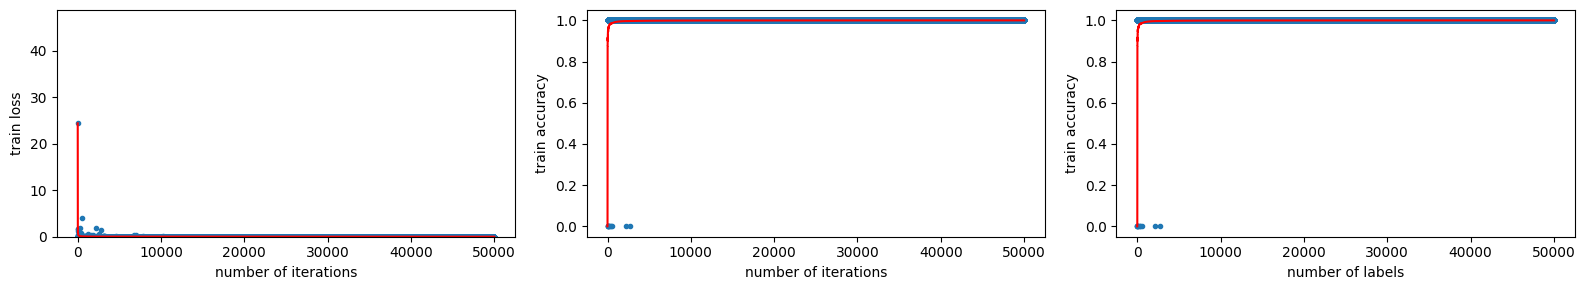

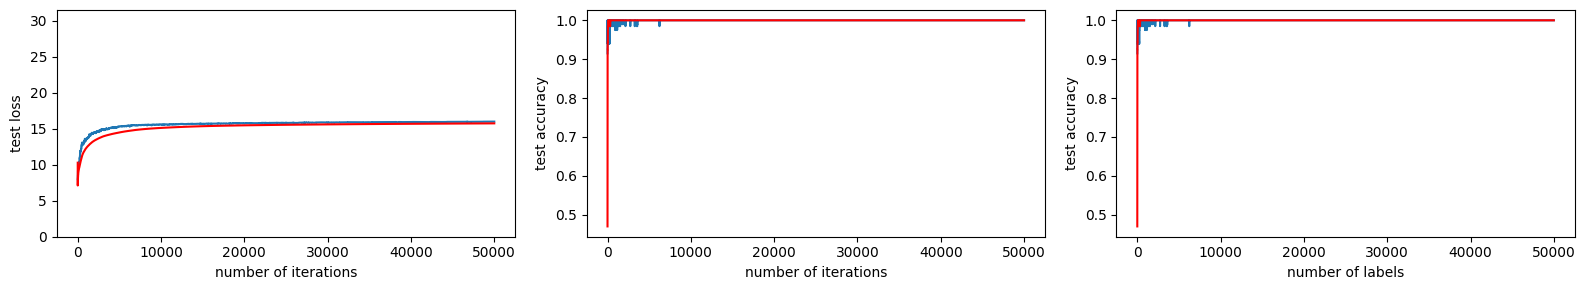

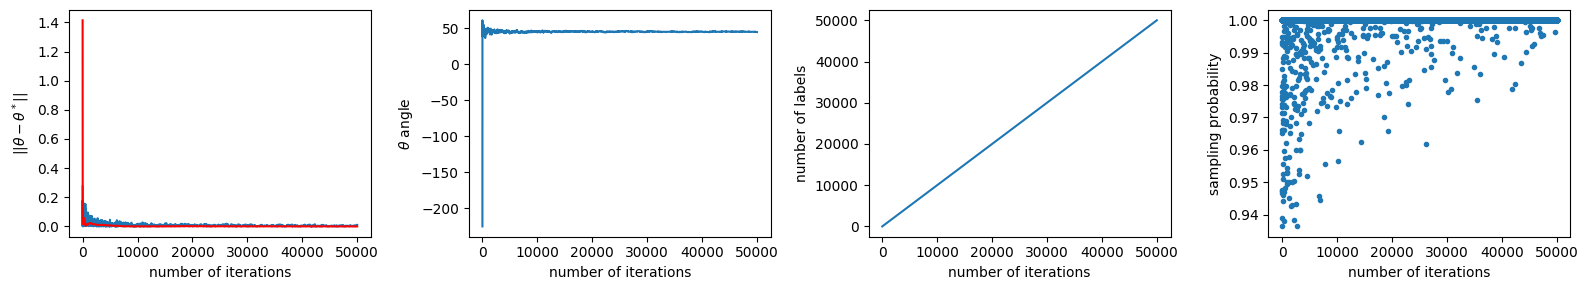

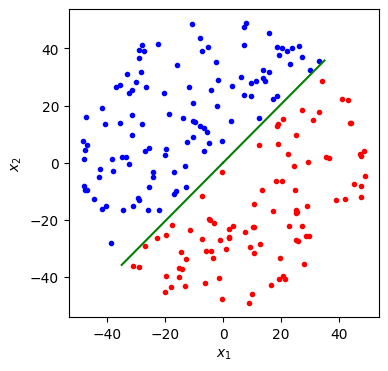

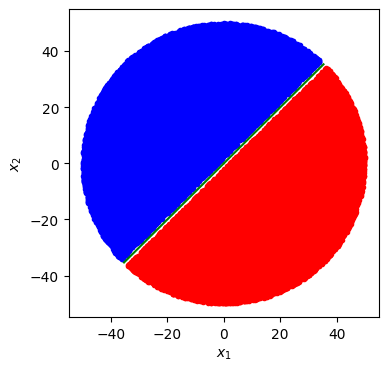

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1

polyakexp = 0.01

beta = 0.25*radius**2
kappa = (1.5*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-bec", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 0.0 theta: [-1.26305388  1.07021544] stheta: [-0.88257129  0.85162082]
loss: 2.5091040356528853e-14 theta: [-1.51080668  1.47183284] stheta: [-1.13060642  1.08826049]
loss: 2.2204460492503136e-16 theta: [-1.65642499  1.70352036] stheta: [-1.28151004  1.25103413]
loss: 0.0 theta: [-1.78222824  1.83569369] stheta: [-1.40676679  1.37195373]
loss: 0.0 theta: [-1.88527097  1.98383815] stheta: [-1.50038631  1.47334476]
loss: 0.0 theta: [-1.96729022  2.10213892] stheta: [-1.57644601  1.5652501 ]
loss: 0.0 theta: [-2.12124706  2.1215364 ] stheta: [-1.64833772  1.6422703 ]
loss: 0.0 theta: [-2.1046394   2.20197001] stheta: [-1.70542953  1.70794468]
loss: 1.5703888795843044e-05 theta: [-2.22647491  2.21058488] stheta: [-1.75675763  1.76240181]
loss: 0.0 theta: [-2.24337734  2.27321793] stheta: [-1.80488063  1.80941319]
loss: 6.129981887903823e-08 theta: [-2.31529184  2.28545378] stheta: [-1.84917071

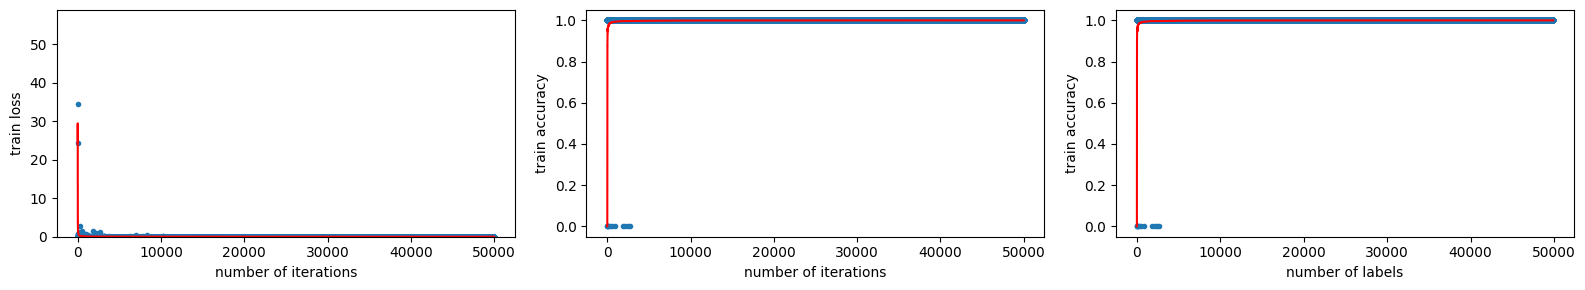

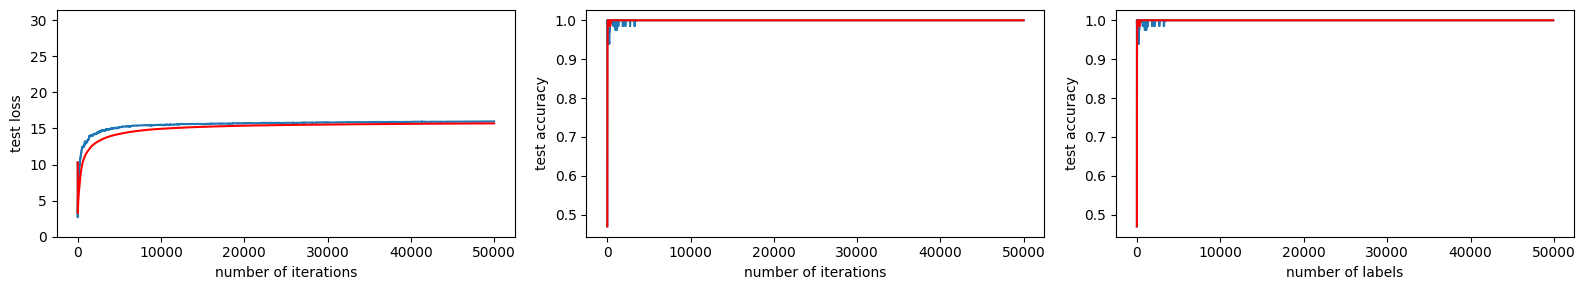

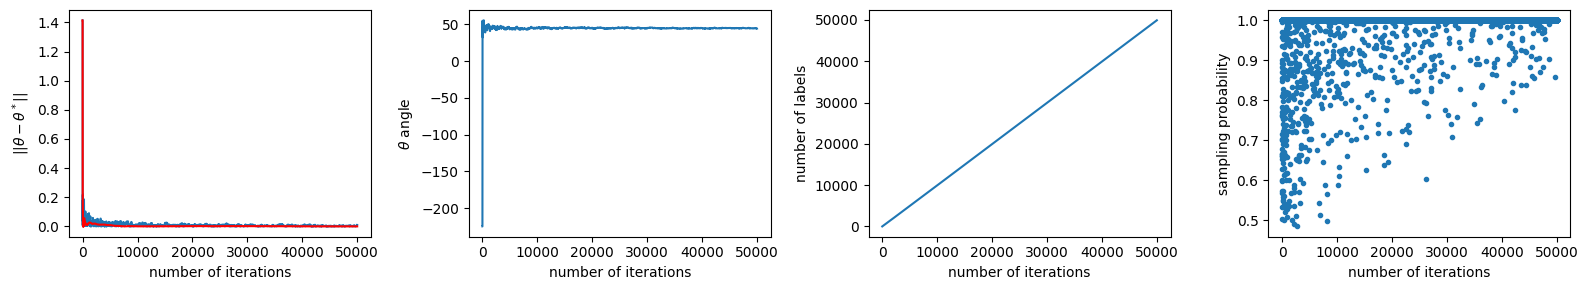

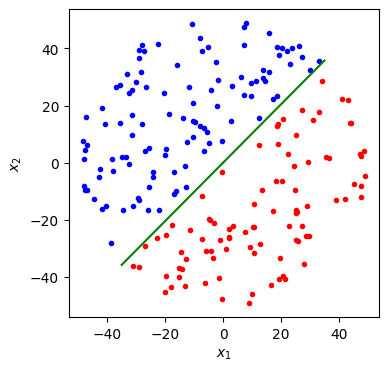

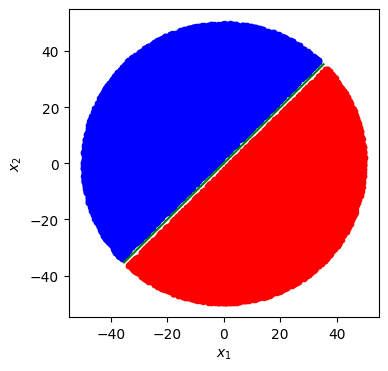

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1

polyakexp = 0.1

beta = 0.25*radius**2
kappa = (1.5*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-bec", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 9.535817414811381e-07 theta: [-0.44509399 -0.24546657] stheta: [-0.6077919  -0.51044705]
loss: 5.423490881801388e-05 theta: [-0.46533283 -0.19632762] stheta: [-0.53218914 -0.36220803]
loss: 0.0007285494878061444 theta: [-0.51079366 -0.18890515] stheta: [-0.51775312 -0.30542064]
loss: 0.0001376893493489502 theta: [-0.55325425 -0.07765806] stheta: [-0.52203443 -0.26427015]
loss: 7.913621983069327e-10 theta: [-0.57392095 -0.06522101] stheta: [-0.53029797 -0.22556369]
loss: 9.141994357523392e-08 theta: [-0.44173458  0.14432694] stheta: [-0.53051399 -0.18740455]
loss: 1.986153650978232 theta: [-0.49235823  0.16261467] stheta: [-0.52071741 -0.13904003]
loss: 0.034407318907733825 theta: [-0.51729052  0.16801148] stheta: [-0.51929086 -0.10094042]
loss: 6.22356670716671 theta: [-0.50313538  0.23751524] stheta: [-0.51671355 -0.0653441 ]
loss: 1.6330758968675732e-10 theta: [-0.50483217  0.27256887] s

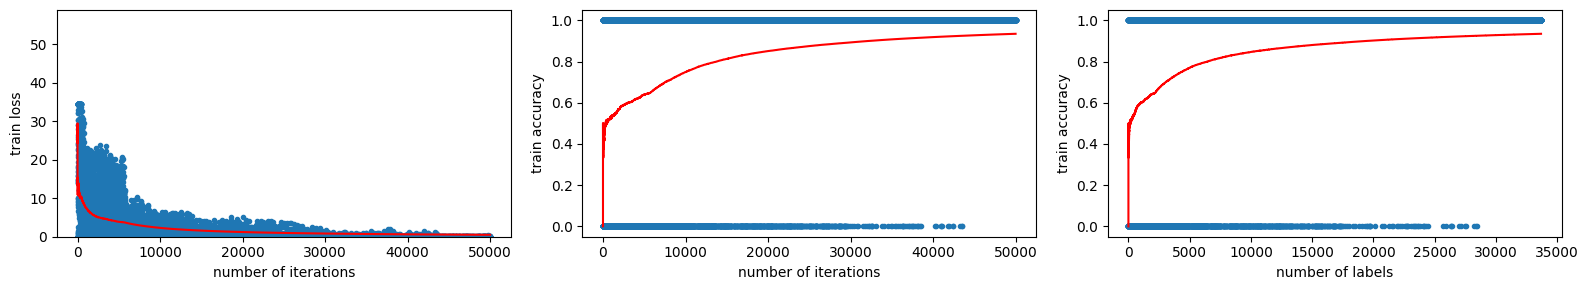

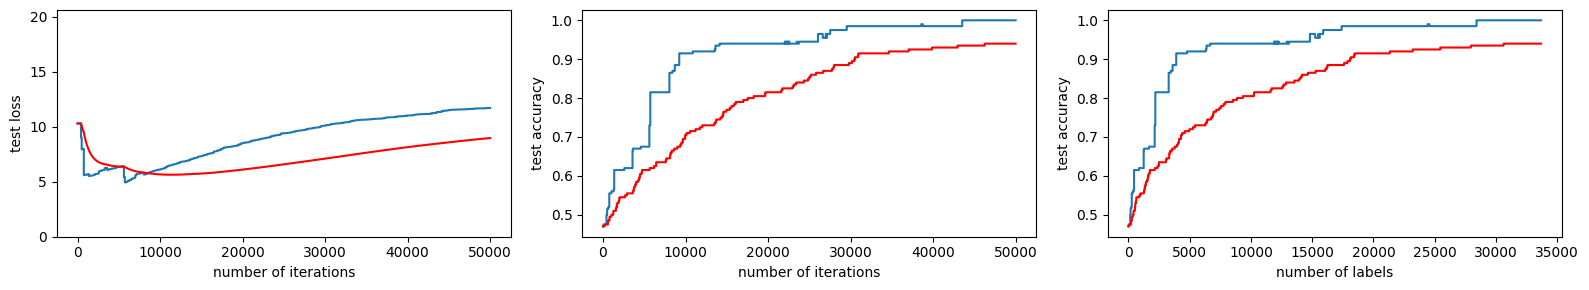

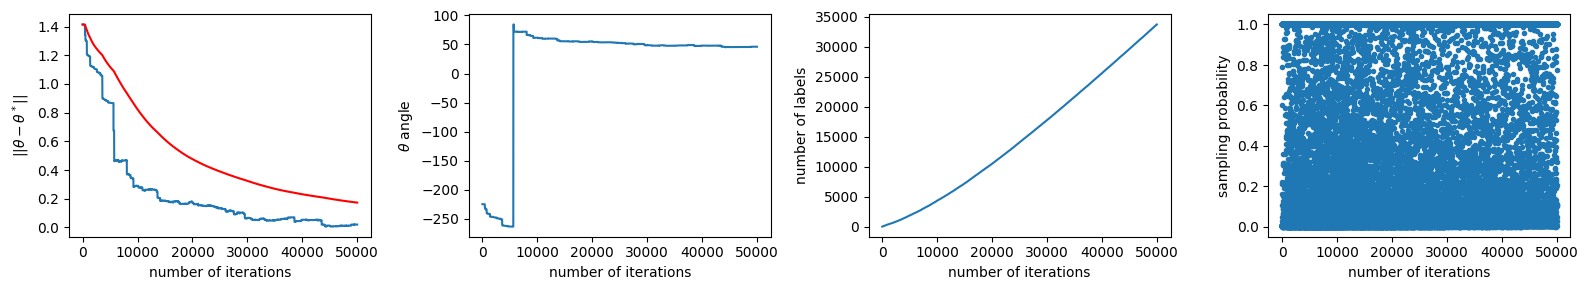

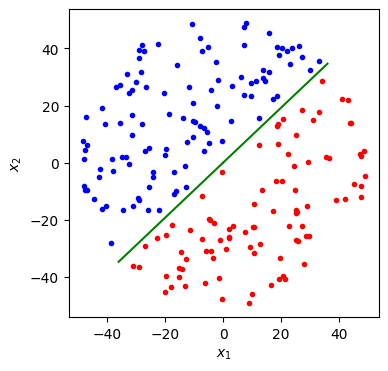

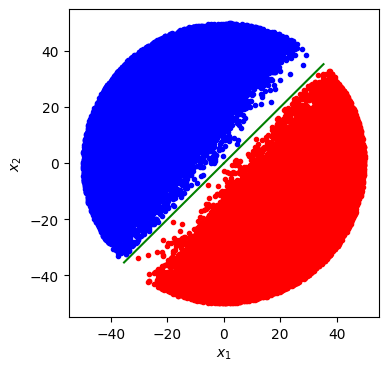

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1

polyakexp = 0.5

beta = 0.25*radius**2
kappa = (1.5*(1/(2*beta)**polyakexp))**(1/(1-polyakexp))

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-bec", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


##Binary cross entropy loss, loss sampling probability

loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 1.4490408872907604e-11 theta: [-0.62057178  0.01135942] stheta: [-0.65253178 -0.29164445]
loss: 4.4308885858671015e-05 theta: [-0.481707    0.33130712] stheta: [-0.59558492 -0.0354803 ]
loss: 7.811336380986958e-05 theta: [-0.45351732  0.36885688] stheta: [-0.55103401  0.09555373]
loss: 6.60983553441019e-06 theta: [-0.4500275   0.37733444] stheta: [-0.52625654  0.16444816]
loss: 1.3561818335098098e-11 theta: [-0.41514029  0.43045995] stheta: [-0.50896828  0.20994993]
loss: 1.2091919497349689e-07 theta: [-0.39587497  0.45523803] stheta: [-0.49135301  0.24907852]
loss: 1.6661569562802817e-05 theta: [-0.39587497  0.45523803] stheta: [-0.47771524  0.27852567]
loss: 6.239636564605566e-06 theta: [-0.40119494  0.45261256] stheta: [-0.46803304  0.30034222]
loss: 0.053413850964295614 theta: [-0.41749448  0.43922479] stheta: [-0.46199634  0.31611846]
loss: 9.587215178846418e-09 theta: [-0.41524258  0

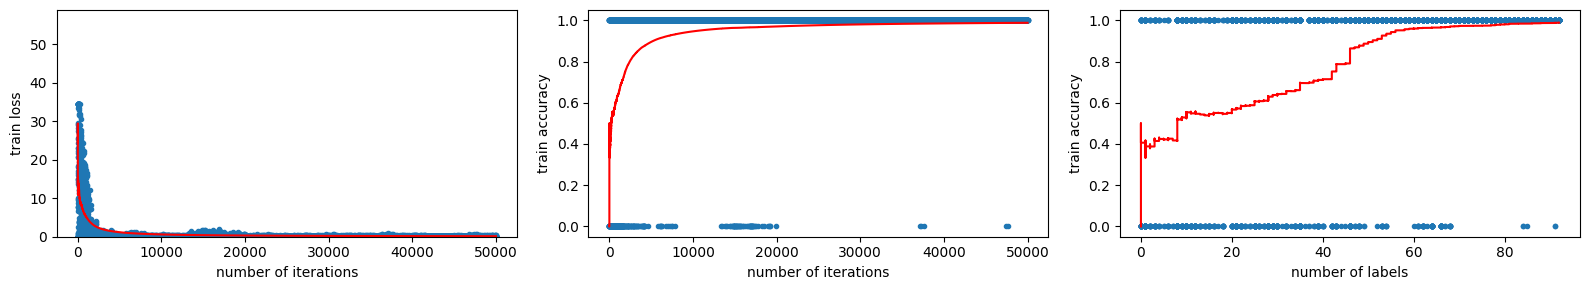

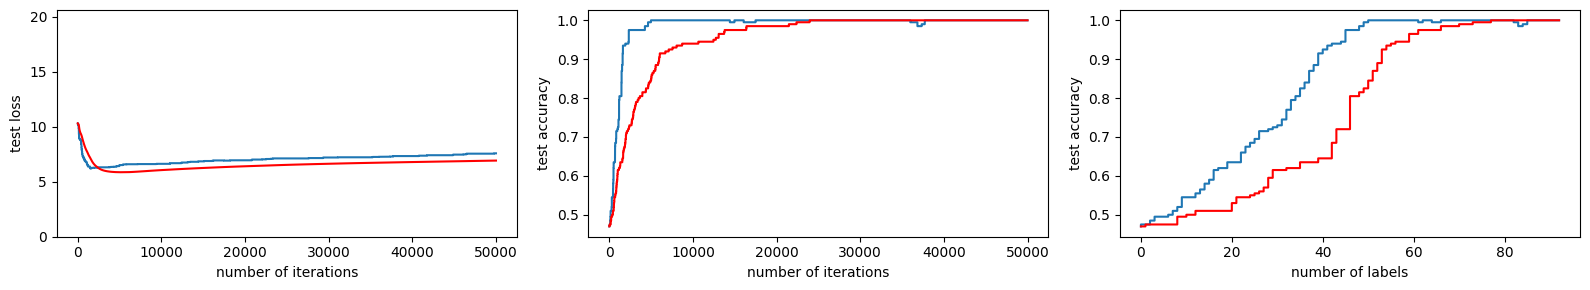

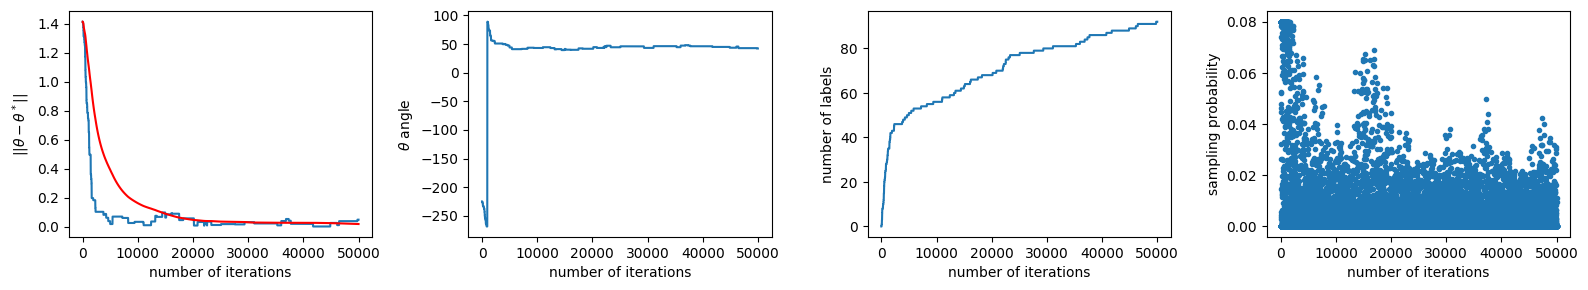

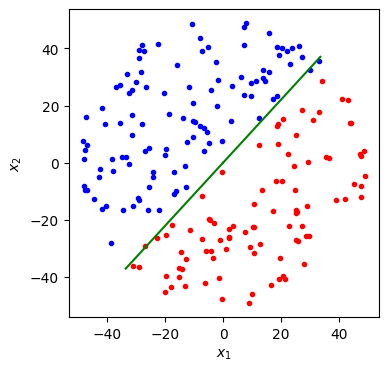

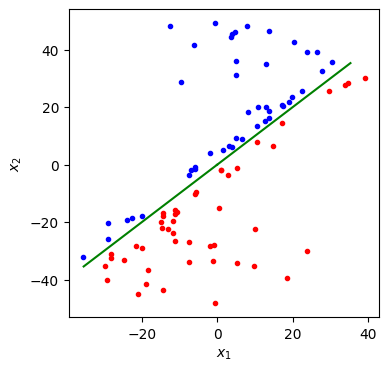

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
beta = 0.25*radius**2
delta = 0.1
kappa = 0.08 * (1-delta)
kappa0 = kappa / (2 * beta)
omega = kappa / (1-delta)

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 3.2336133771150195e-11 theta: [-0.71988231 -0.28826954] stheta: [-0.72205444 -0.51665615]
loss: 7.291707541677021e-07 theta: [-0.67228574 -0.03959867] stheta: [-0.70842004 -0.33162537]
loss: 5.517087835945957e-05 theta: [-0.531925    0.20565216] stheta: [-0.67394167 -0.20140381]
loss: 1.0335182232679544e-05 theta: [-0.45611963  0.32535851] stheta: [-0.62758124 -0.08148975]
loss: 2.4174995339202536e-11 theta: [-0.45611963  0.32535851] stheta: [-5.93295772e-01 -1.36369587e-04]
loss: 4.346941667842747e-08 theta: [-0.4364754  0.3601044] stheta: [-0.56957758  0.05593025]
loss: 0.0007447755088296372 theta: [-0.43074815  0.37133502] stheta: [-0.55007984  0.10013018]
loss: 7.263375206555479e-05 theta: [-0.43074815  0.37133502] stheta: [-0.53516524  0.13402655]
loss: 0.5675754466027401 theta: [-0.43074815  0.37133502] stheta: [-0.52356463  0.16039123]
loss: 1.0128163359321748e-08 theta: [-0.4136220

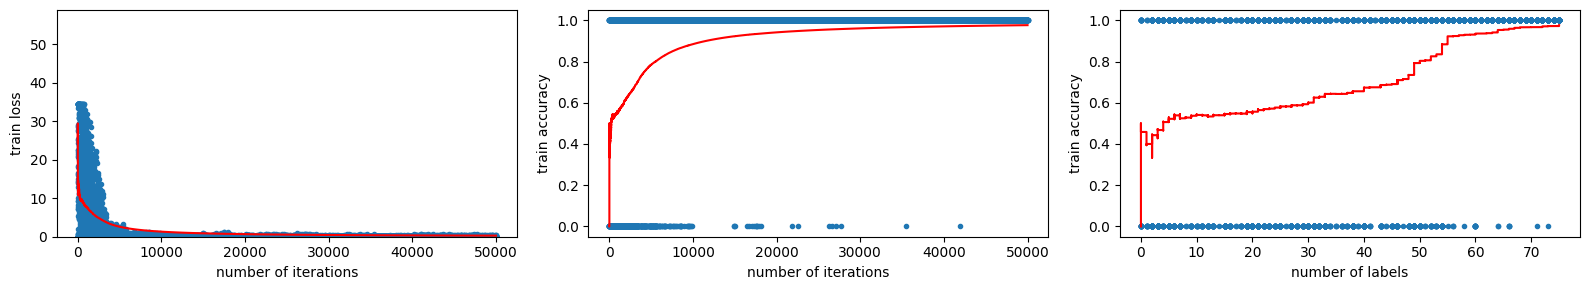

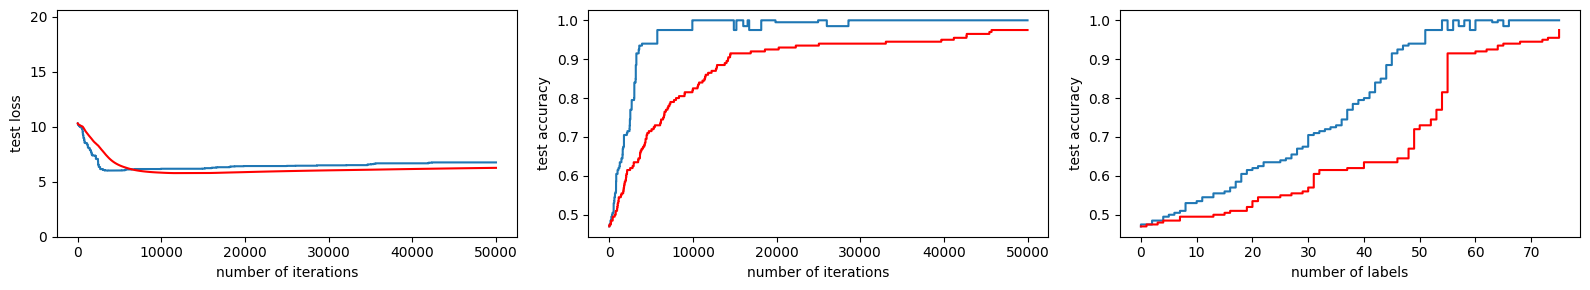

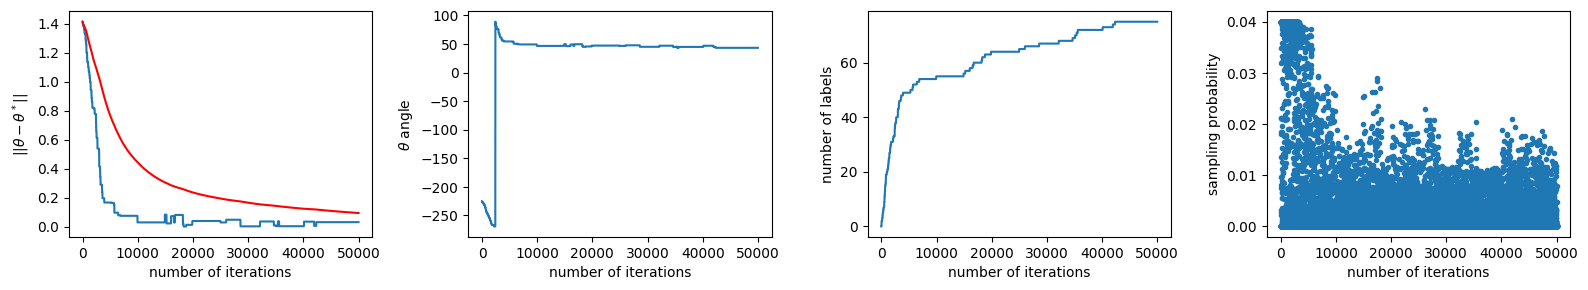

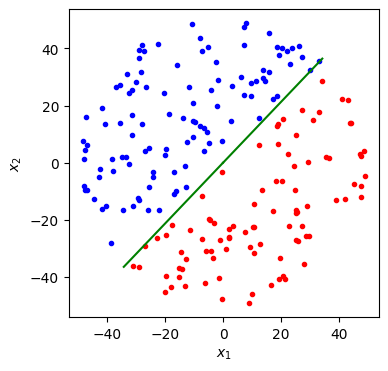

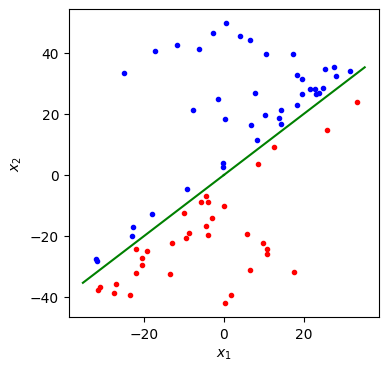

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
beta = 0.25*radius**2
delta = 0.1
kappa = 0.04 * (1-delta)
kappa0 = kappa / (2 * beta)
omega = kappa / (1-delta)

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 8.9864893344915e-10 theta: [-0.71185732 -0.47707536] stheta: [-0.71101264 -0.59980545]
loss: 3.031528559170008e-07 theta: [-0.71017935 -0.3305027 ] stheta: [-0.70870259 -0.49094943]
loss: 7.305468412908117e-05 theta: [-0.64327272 -0.16269324] stheta: [-0.69777784 -0.40912121]
loss: 3.207216157609147e-05 theta: [-0.59513253 -0.00997298] stheta: [-0.6814144  -0.33319771]
loss: 1.6753232136306227e-10 theta: [-0.53655949  0.0802586 ] stheta: [-0.65531282 -0.25510769]
loss: 5.7705259626189805e-09 theta: [-0.52501386  0.10345802] stheta: [-0.63406499 -0.19686567]
loss: 2.782862589922125 theta: [-0.50871634  0.14671439] stheta: [-0.61661558 -0.14891404]
loss: 0.010997001652159952 theta: [-0.48444099  0.20423117] stheta: [-0.60226479 -0.11013515]
loss: 5.3653466934133345 theta: [-0.4647105   0.23095761] stheta: [-0.5884338  -0.07420582]
loss: 1.1100680381070443e-09 theta: [-0.46181782  0.23858759]

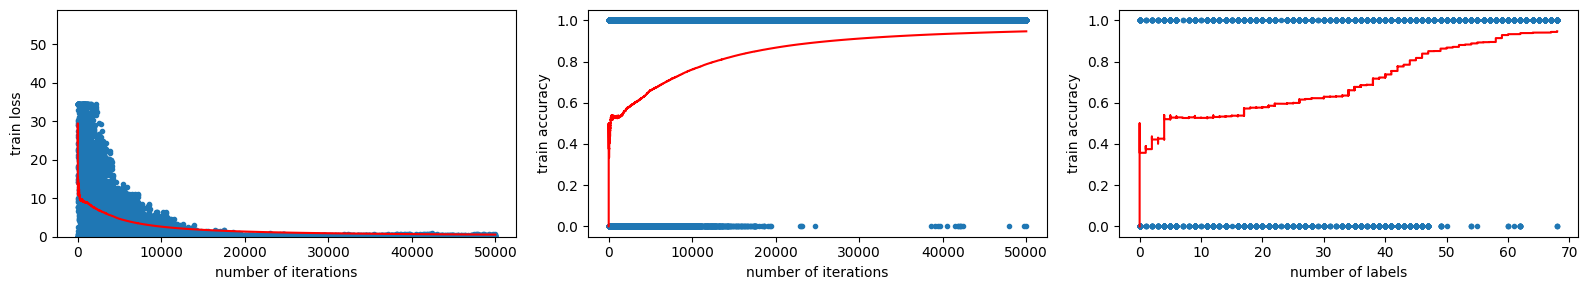

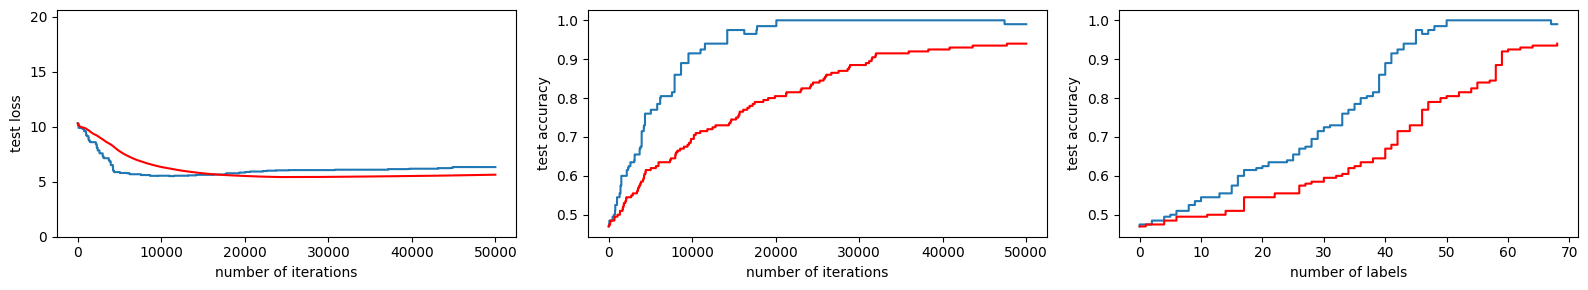

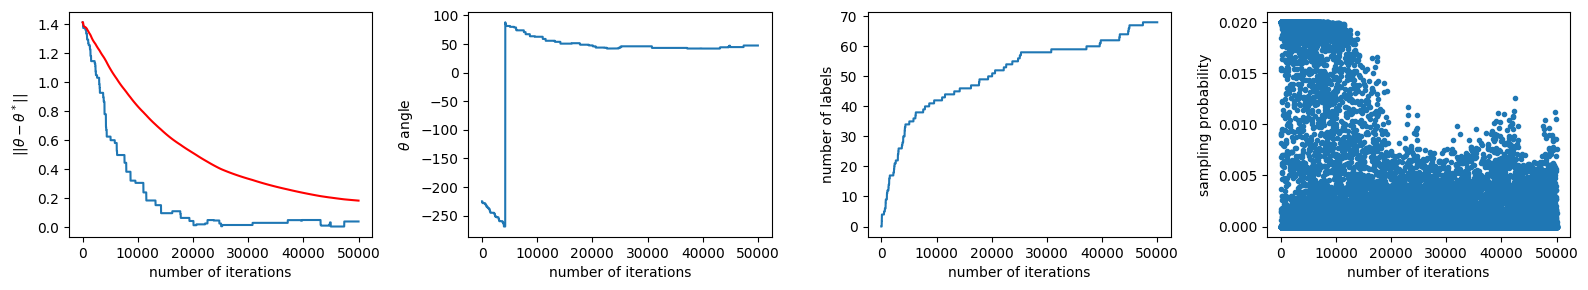

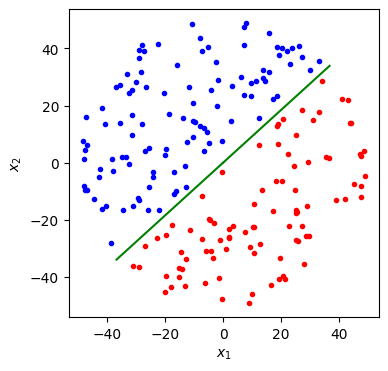

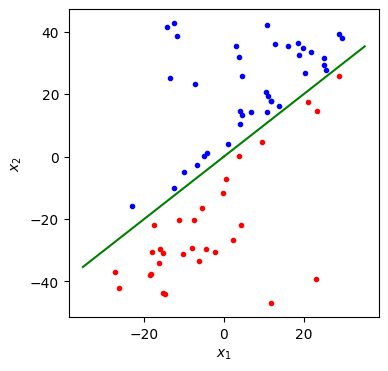

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
beta = 0.25*radius**2
delta = 0.1
kappa = 0.02 * (1-delta)
kappa0 = kappa / (2 * beta)
omega = kappa / (1-delta)

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 1.1168843627729698e-13 theta: [-0.7158119   0.07819251] stheta: [-0.71503901 -0.06021862]
loss: 3.0212125946295874e-07 theta: [-0.7158119   0.07819251] stheta: [-0.71542526  0.00895236]
loss: 5.737175498068518e-06 theta: [-0.7158119   0.07819251] stheta: [-0.7155541   0.03202472]
loss: 1.3336443647351065e-06 theta: [-0.56971835  0.33025799] stheta: [-0.70371489  0.06410198]
loss: 2.643441021632847e-13 theta: [-0.56971835  0.33025799] stheta: [-0.67692094  0.11732254]
loss: 4.4890347005250185e-10 theta: [-0.56971835  0.33025799] stheta: [-0.65905682  0.15280587]
loss: 0.03489837125354233 theta: [-0.56971835  0.33025799] stheta: [-0.646296    0.17815255]
loss: 0.00036321511924715665 theta: [-0.56971835  0.33025799] stheta: [-0.63672499  0.19716335]
loss: 5.009399091488705 theta: [-0.56971835  0.33025799] stheta: [-0.62928064  0.21195   ]
loss: 9.085843188968633e-12 theta: [-0.56971835  0.330

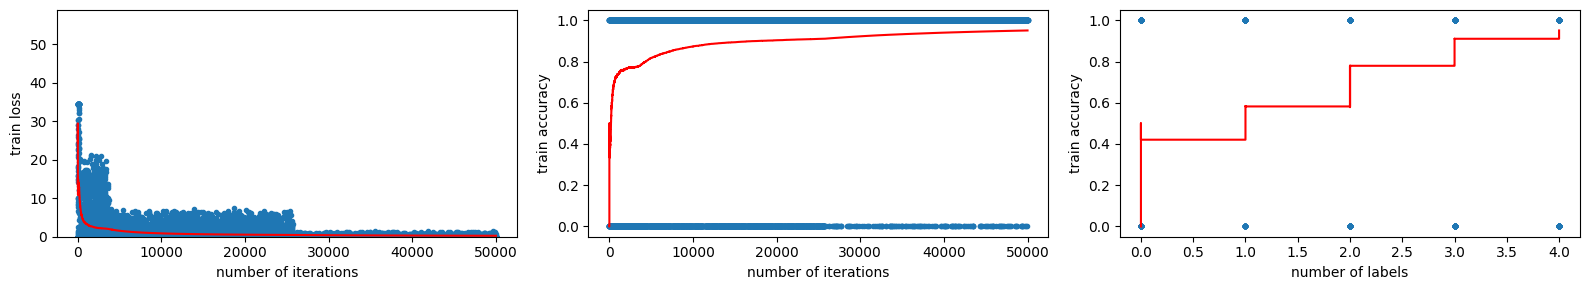

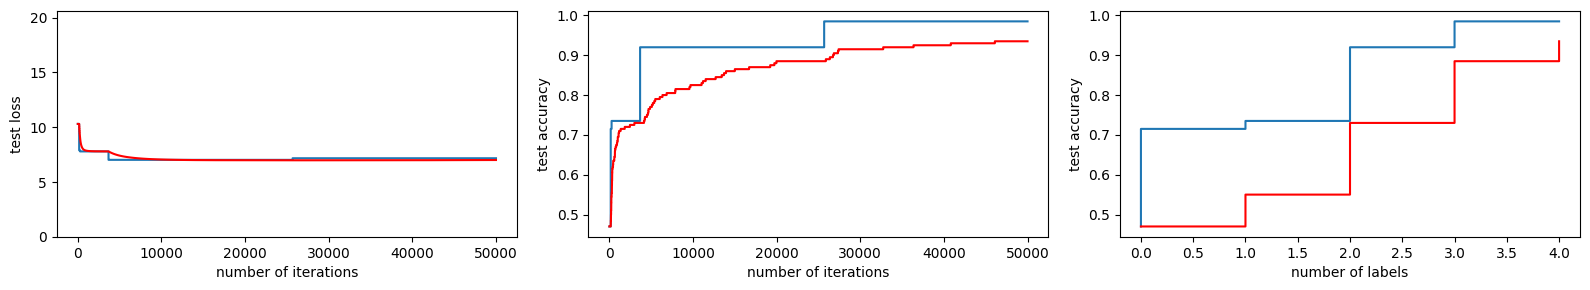

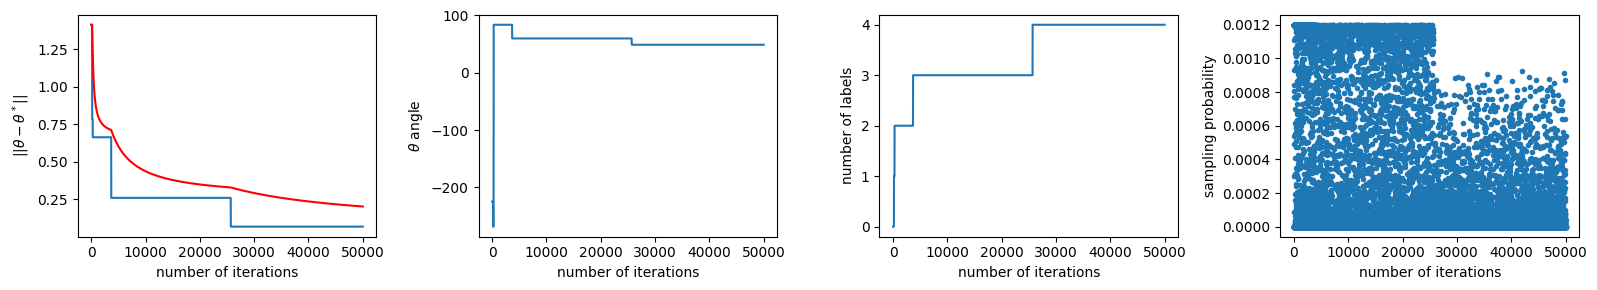

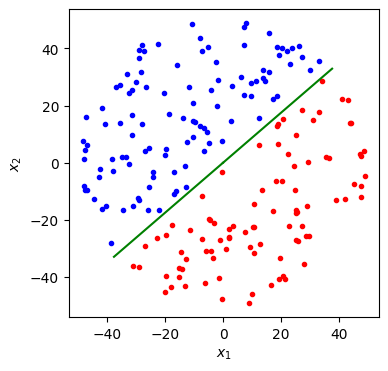

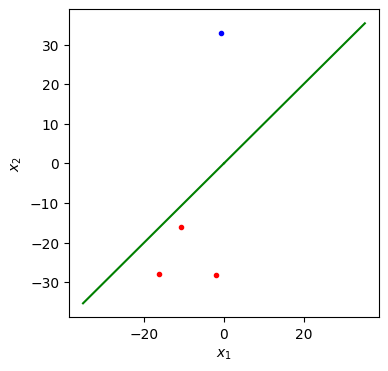

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1
beta = 0.25*radius**2
kappa = 1.5 / (2*beta)
omega = kappa

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70710678 -0.70710678] stheta: [-0.70710678 -0.70710678]
loss: 2.774110278675834e-09 theta: [-0.75347795 -0.65234562] stheta: [-0.71502833 -0.69775198]
loss: 2.5486220914796555e-06 theta: [-0.60996646 -0.24417147] stheta: [-0.70125239 -0.58122701]
loss: 0.00019917119619085663 theta: [-0.60996646 -0.24417147] stheta: [-0.67083388 -0.4689126 ]
loss: 0.0002999442060396861 theta: [-0.60996646 -0.24417147] stheta: [-0.65562083 -0.41274136]
loss: 7.853694170310492e-09 theta: [-0.60996646 -0.24417147] stheta: [-0.64649178 -0.37903413]
loss: 1.861699908779985e-07 theta: [-0.42668269  0.10246469] stheta: [-0.61377707 -0.31456859]
loss: 3.1177966151219447 theta: [-0.42668269  0.10246469] stheta: [-0.58705311 -0.25500092]
loss: 0.16572747299700943 theta: [-0.42668269  0.10246469] stheta: [-0.56700932 -0.2103233 ]
loss: 8.572654068648308 theta: [-0.42668269  0.10246469] stheta: [-0.5514192  -0.17557294]
loss: 2.3659769645805865e-08 theta: [-0.39296577  0.15900834

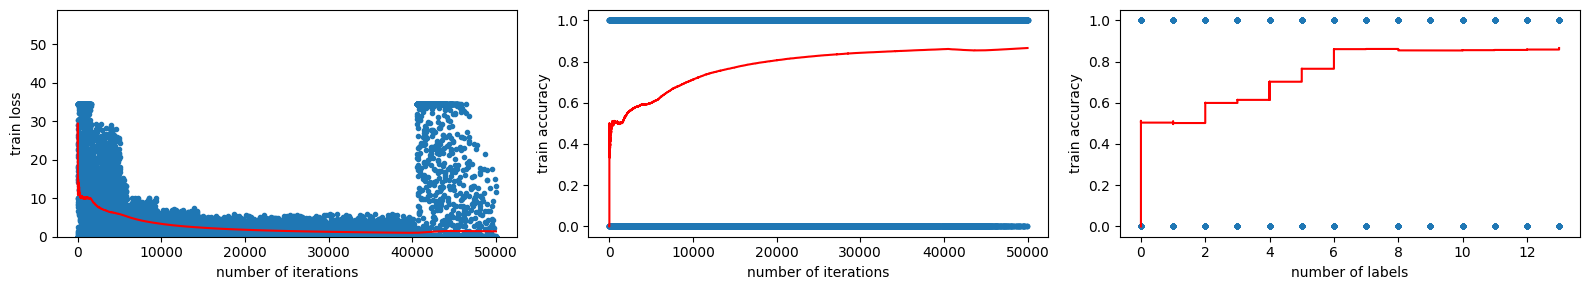

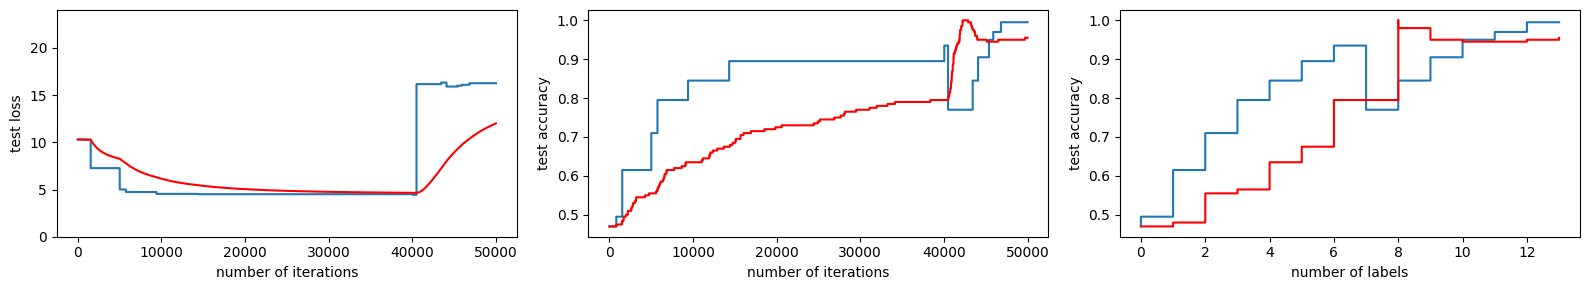

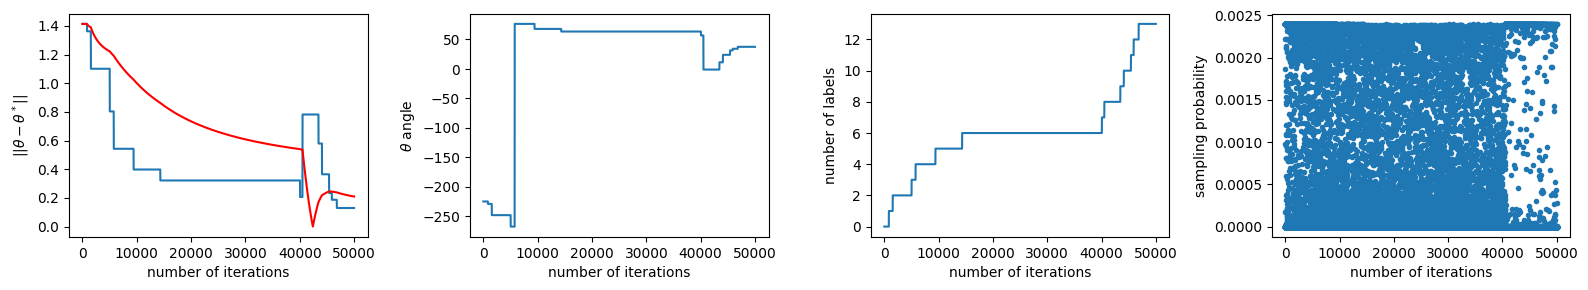

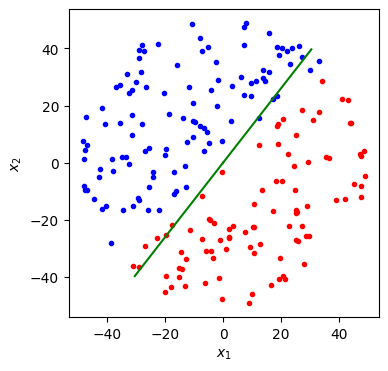

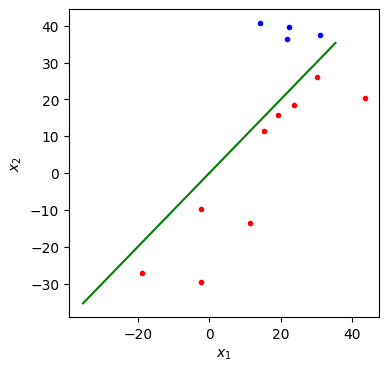

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1
beta = 0.25*radius**2
kappa = 1.5 / (2*beta)
omega = 2 * kappa

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)


loss: 24.385130865312046 theta: [-0.70706331 -0.70621884] stheta: [-0.70710678 -0.70710678]
loss: 3.783578790769309e-09 theta: [-0.65509737 -0.42499885] stheta: [-0.67969741 -0.55670802]
loss: 2.7414956587219656e-06 theta: [-0.60640045 -0.25109732] stheta: [-0.65508796 -0.44421192]
loss: 0.00018231090443311174 theta: [-0.57672601 -0.13339213] stheta: [-0.63595796 -0.35962638]
loss: 0.000115231391870472 theta: [-0.54899916 -0.05393975] stheta: [-0.61779791 -0.29257322]
loss: 9.9903541045331e-10 theta: [-0.53172     0.00290634] stheta: [-0.60182107 -0.23844986]
loss: 1.2564272035102956e-08 theta: [-0.50839615  0.05891682] stheta: [-0.58780636 -0.19328269]
loss: 4.424916139786887 theta: [-0.49023534  0.09491831] stheta: [-0.57509526 -0.15467255]
loss: 0.11578422122374027 theta: [-0.47873536  0.12098007] stheta: [-0.56377469 -0.12190477]
loss: 8.046693000213741 theta: [-0.46642772  0.1520662 ] stheta: [-0.55359027 -0.09291049]
loss: 7.696456808168025e-10 theta: [-0.46992952  0.23055132] st

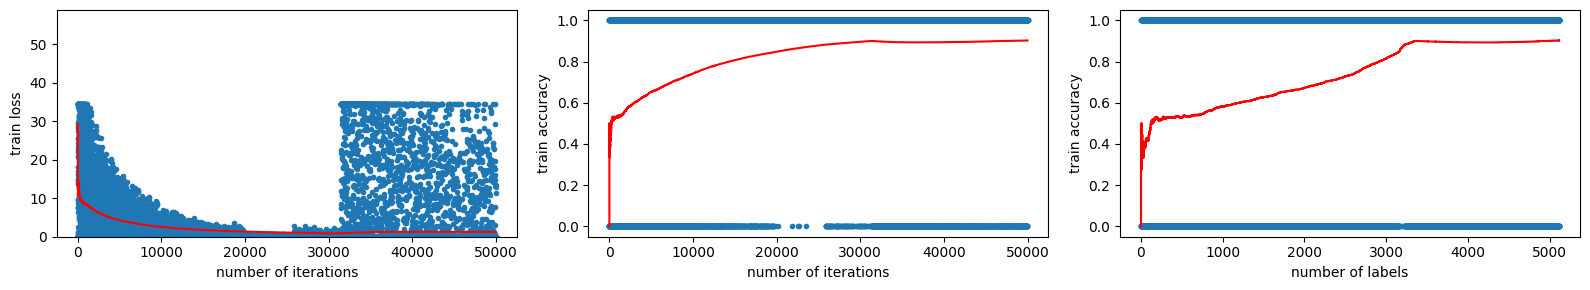

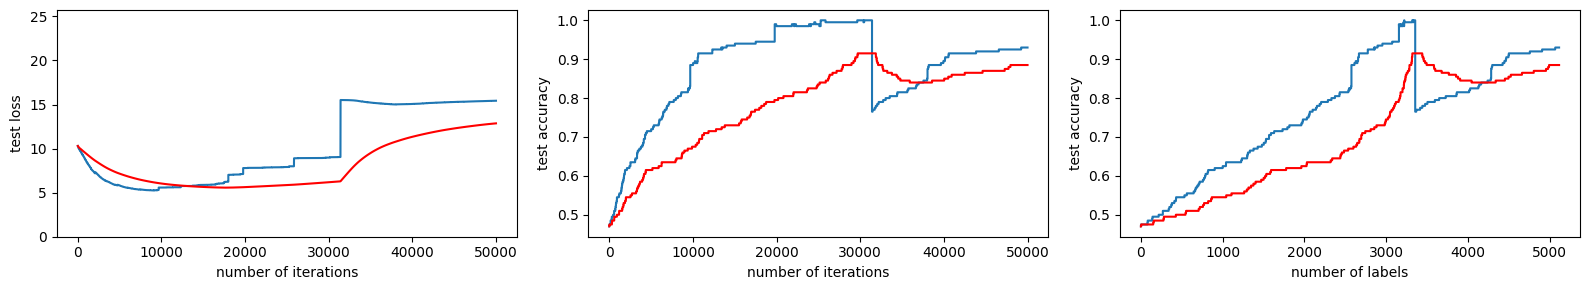

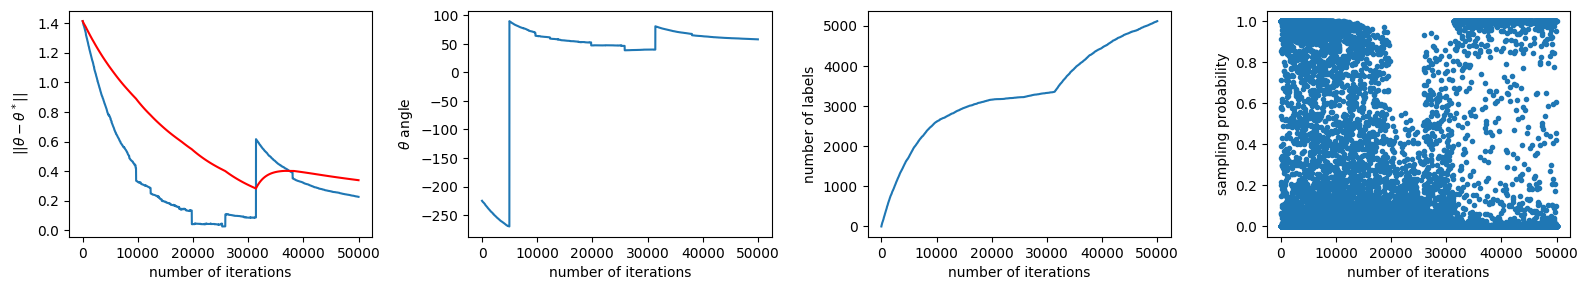

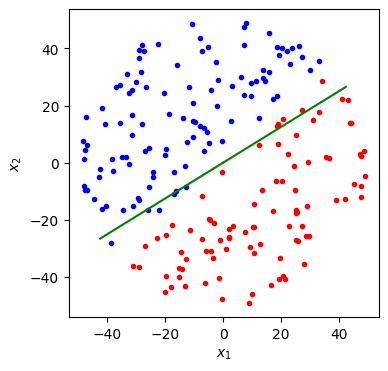

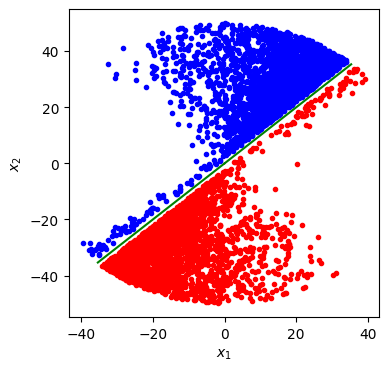

In [ ]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss

eta = 1
kappa0 = 1
beta = 0.25*radius**2
kappa = 1.5 / (2*beta)
omega = 1

lam = 0
accuracy = accuracy_prob
losses, losses_test, slosses_test, Delta, sDelta, labeled, theta, stheta, probs, accuracies, accuracies_test, saccuracies_test, samples, thetas = train_model(X, y, Xtest, ytest, theta_star, mode = "polyak-becpi", eta = eta, lam = lam)
plot_eval(losses, losses_test, slosses_test, Delta, sDelta, labeled, probs, accuracies, accuracies_test, saccuracies_test, thetas)
plot_data(Xtest, ytest, theta, radius)
plot_data(X[samples], y[samples], theta_star, radius)
